# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Consumption, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using only 10 sign-adjusted topics (BCC) (out of 200 topics estimated on articles published before 2010 using all sources) most correlated with Consumption growth. I use text data to forecast Consumption growth.

## Experiment Details

- **Data Sources:** 10 sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1
  - **Factor Order:** 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'              # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
with_text = True
only_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

num_factors = 1
order = 3
        
# Define model-specific parameters
factor_multiplicities = {'Global': num_factors}
factor_orders = {'Global': order}

# Prepare lists to store each quarter's forecasts and row labels
forecasts_all_quarters = []
row_labels = []

# Start timing for this model
start_time = time.time()

# Loop over each forecast month, get the forecasts, and store the results
for fm in forecast_months:
    # Use the forecast_month string as the row label
    row_labels.append(fm)

    # Run the forecast function for this quarter
    forecasts_dict = DFM_function.get_forecasts(
        forecast_month = fm,
        q_var = q_var,
        additional_factors = additional_factors,
        factor_multiplicities = factor_multiplicities,
        factor_orders = factor_orders,
        start = start,
        text_type = text_type,
        estimation_period = estimation_period,
        num_topics = num_topics,
        source = source,
        selected = selected,
        with_text = with_text,
        only_text = only_text
    )

    # Obtain the correct ordering of vintages
    vintages_order = DFM_function.vintage_dates(fm)
    # Extract the forecast value for each vintage in that order
    quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
    forecasts_all_quarters.append(quarter_forecasts)

# Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)

# Stop timing for this model and print elapsed time
elapsed = time.time() - start_time
elapsed_time = datetime.timedelta(seconds=elapsed)
print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

# Construct the output file name
factors_str = "_".join([
    f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
    for factor in factor_multiplicities])
file_name = f"forecasts_{q_var}_{factors_str}.csv"

# Save the CSV file in a subfolder 
output_path = os.path.join(f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", file_name)
results.to_csv(output_path, index=True)

# ----- MSE Calculation -----
# Load forecasts
forecasts = pd.read_csv(output_path, index_col=0)
# Make sure the index is a column named "date"
forecasts.index.name = "date"
forecasts.reset_index(inplace=True)

# Merge dfs by date 
merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

# Calculate the Mean Squared Error (MSE) for each vintage column
mse_dict = {}
for col in vintage_col_names:
    mse = ((merged[col] - merged["growth"]) ** 2).mean()
    mse_dict[col] = mse

# Create a df with one row (the MSE values for each forecasting horizon)
mse_df = pd.DataFrame(mse_dict, index=[0])

# Save MSE results to CSV
mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
mse_output_path = os.path.join(f"../MSE/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", mse_file_name)
mse_df.to_csv(mse_output_path, index=False)

EM start iterations, llf=-2712.4
EM iteration 100, llf=-2641.3, convergence criterion=2.6626e-05
EM iteration 200, llf=-2636.6, convergence criterion=7.8521e-06
EM iteration 300, llf=-2635.5, convergence criterion=2.3098e-06
EM iteration 400, llf=-2635.1, convergence criterion=1.1072e-06
EM converged at iteration 418, llf=-2635, convergence criterion=9.9708e-07 < tolerance=1e-06
EM start iterations, llf=-2712.4
EM iteration 100, llf=-2641.3, convergence criterion=2.6626e-05
EM iteration 200, llf=-2636.6, convergence criterion=7.8521e-06
EM iteration 300, llf=-2635.5, convergence criterion=2.3098e-06
EM iteration 400, llf=-2635.1, convergence criterion=1.1072e-06
EM converged at iteration 418, llf=-2635, convergence criterion=9.9708e-07 < tolerance=1e-06
EM start iterations, llf=-2725.4
EM iteration 100, llf=-2654.4, convergence criterion=2.4913e-05
EM iteration 200, llf=-2649.7, convergence criterion=8.5058e-06
EM iteration 300, llf=-2648.5, convergence criterion=2.4532e-06
EM iteratio

EM iteration 400, llf=-2753.7, convergence criterion=1.1571e-06
EM converged at iteration 426, llf=-2753.6, convergence criterion=9.9449e-07 < tolerance=1e-06
EM start iterations, llf=-2832.8
EM iteration 100, llf=-2760.2, convergence criterion=2.4362e-05
EM iteration 200, llf=-2755.4, convergence criterion=8.466e-06
EM iteration 300, llf=-2754.1, convergence criterion=2.4485e-06
EM iteration 400, llf=-2753.7, convergence criterion=1.1571e-06
EM converged at iteration 426, llf=-2753.6, convergence criterion=9.9449e-07 < tolerance=1e-06
EM start iterations, llf=-2845.5
EM iteration 100, llf=-2774, convergence criterion=1.1844e-05
EM iteration 200, llf=-2770.6, convergence criterion=1.0999e-05
EM iteration 300, llf=-2768.4, convergence criterion=5.0525e-06
EM iteration 400, llf=-2767.5, convergence criterion=2.3792e-06
EM iteration 500, llf=-2767, convergence criterion=1.3565e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2767, convergence criterio

X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2767, convergence criterion=1.3565e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2845.5
EM iteration 100, llf=-2774, convergence criterion=1.1844e-05
EM iteration 200, llf=-2770.6, convergence criterion=1.0999e-05
EM iteration 300, llf=-2768.4, convergence criterion=5.0525e-06
EM iteration 400, llf=-2767.5, convergence criterion=2.3792e-06
EM iteration 500, llf=-2767, convergence criterion=1.3565e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2767, convergence criterion=1.3565e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2767, convergence criterion=1.3565e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2860.2
EM iteration 100, llf=-2788.7, convergence criterion=9.5668e-06
EM iteration 200, llf=-2785.8, convergence criterion=1.0128e-05
EM iteration 300, llf=-2783.6, convergence criterion=5.6637e-06
EM iteration 400, llf=-2782.4, convergence criterion=2.8282e-06
EM iteration 500, llf=-2781.8, convergence criterion=1.6064e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2781.8, convergence criterion=1.6064e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2781.8, convergence criterion=1.6064e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2860.2
EM iteration 100, llf=-2788.7, convergence criterion=9.5668e-06
EM iteration 200, llf=-2785.8, convergence criterion=1.0128e-05
EM iteration 300, llf=-2783.6, convergence criterion=5.6637e-06
EM iteration 400, llf=-2782.4, convergence criterion=2.8282e-06
EM iteration 500, llf=-2781.8, convergence criterion=1.6064e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2781.8, convergence criterion=1.6064e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2781.8, convergence criterion=1.6064e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2874.2
EM iteration 100, llf=-2802.7, convergence criterion=8.5645e-06
EM iteration 200, llf=-2799.9, convergence criterion=1.0035e-05
EM iteration 300, llf=-2797.6, convergence criterion=6.1622e-06
EM iteration 400, llf=-2796.4, convergence criterion=3.0928e-06
EM iteration 500, llf=-2795.7, convergence criterion=1.7167e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2795.7, convergence criterion=1.7167e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2795.7, convergence criterion=1.7167e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2874.2
EM iteration 100, llf=-2802.7, convergence criterion=8.5645e-06
EM iteration 200, llf=-2799.9, convergence criterion=1.0035e-05
EM iteration 300, llf=-2797.6, convergence criterion=6.1622e-06
EM iteration 400, llf=-2796.4, convergence criterion=3.0928e-06
EM iteration 500, llf=-2795.7, convergence criterion=1.7167e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2795.7, convergence criterion=1.7167e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2795.7, convergence criterion=1.7167e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2874.2
EM iteration 100, llf=-2802.7, convergence criterion=8.5645e-06
EM iteration 200, llf=-2799.9, convergence criterion=1.0035e-05
EM iteration 300, llf=-2797.6, convergence criterion=6.1622e-06
EM iteration 400, llf=-2796.4, convergence criterion=3.0928e-06
EM iteration 500, llf=-2795.7, convergence criterion=1.7167e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2795.7, convergence criterion=1.7167e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2795.7, convergence criterion=1.7167e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2887.5
EM iteration 100, llf=-2814.5, convergence criterion=1.3542e-05
EM iteration 200, llf=-2811, convergence criterion=9.652e-06
EM iteration 300, llf=-2809.2, convergence criterion=4.1566e-06
EM iteration 400, llf=-2808.3, convergence criterion=2.0309e-06
EM iteration 500, llf=-2807.9, convergence criterion=1.1945e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2807.9, convergence criterion=1.1945e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2807.9, convergence criterion=1.1945e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2887.5
EM iteration 100, llf=-2814.5, convergence criterion=1.3542e-05
EM iteration 200, llf=-2811, convergence criterion=9.652e-06
EM iteration 300, llf=-2809.2, convergence criterion=4.1566e-06
EM iteration 400, llf=-2808.3, convergence criterion=2.0309e-06
EM iteration 500, llf=-2807.9, convergence criterion=1.1945e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2807.9, convergence criterion=1.1945e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2807.9, convergence criterion=1.1945e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2902.1
EM iteration 100, llf=-2828.6, convergence criterion=1.4865e-05
EM iteration 200, llf=-2824.9, convergence criterion=9.1592e-06
EM iteration 300, llf=-2823.2, convergence criterion=3.7701e-06
EM iteration 400, llf=-2822.5, convergence criterion=1.863e-06
EM iteration 500, llf=-2822.1, convergence criterion=1.1105e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2822.1, convergence criterion=1.1105e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2822.1, convergence criterion=1.1105e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2902.1
EM iteration 100, llf=-2828.6, convergence criterion=1.4865e-05
EM iteration 200, llf=-2824.9, convergence criterion=9.1592e-06
EM iteration 300, llf=-2823.2, convergence criterion=3.7701e-06
EM iteration 400, llf=-2822.5, convergence criterion=1.863e-06
EM iteration 500, llf=-2822.1, convergence criterion=1.1105e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2822.1, convergence criterion=1.1105e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2822.1, convergence criterion=1.1105e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2913
EM iteration 100, llf=-2839.5, convergence criterion=1.2201e-05
EM iteration 200, llf=-2836.2, convergence criterion=9.3771e-06
EM iteration 300, llf=-2834.4, convergence criterion=4.3348e-06
EM iteration 400, llf=-2833.5, convergence criterion=2.154e-06
EM iteration 500, llf=-2833, convergence criterion=1.2667e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2833, convergence criterion=1.2667e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2833, convergence criterion=1.2667e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2913
EM iteration 100, llf=-2839.5, convergence criterion=1.2201e-05
EM iteration 200, llf=-2836.2, convergence criterion=9.3771e-06
EM iteration 300, llf=-2834.4, convergence criterion=4.3348e-06
EM iteration 400, llf=-2833.5, convergence criterion=2.154e-06
EM iteration 500, llf=-2833, convergence criterion=1.2667e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2833, convergence criterion=1.2667e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2833, convergence criterion=1.2667e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2913
EM iteration 100, llf=-2839.5, convergence criterion=1.2201e-05
EM iteration 200, llf=-2836.2, convergence criterion=9.3771e-06
EM iteration 300, llf=-2834.4, convergence criterion=4.3348e-06
EM iteration 400, llf=-2833.5, convergence criterion=2.154e-06
EM iteration 500, llf=-2833, convergence criterion=1.2667e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2833, convergence criterion=1.2667e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2833, convergence criterion=1.2667e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2924.3
EM iteration 100, llf=-2850.3, convergence criterion=1.3183e-05
EM iteration 200, llf=-2846.9, convergence criterion=9.0248e-06
EM iteration 300, llf=-2845.2, convergence criterion=4.0124e-06
EM iteration 400, llf=-2844.4, convergence criterion=2.0122e-06
EM iteration 500, llf=-2843.9, convergence criterion=1.1961e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2843.9, convergence criterion=1.1961e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2843.9, convergence criterion=1.1961e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2924.3
EM iteration 100, llf=-2850.3, convergence criterion=1.3183e-05
EM iteration 200, llf=-2846.9, convergence criterion=9.0248e-06
EM iteration 300, llf=-2845.2, convergence criterion=4.0124e-06
EM iteration 400, llf=-2844.4, convergence criterion=2.0122e-06
EM iteration 500, llf=-2843.9, convergence criterion=1.1961e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2843.9, convergence criterion=1.1961e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2843.9, convergence criterion=1.1961e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2939.1
EM iteration 100, llf=-2864.8, convergence criterion=1.3691e-05
EM iteration 200, llf=-2861.3, convergence criterion=8.994e-06
EM iteration 300, llf=-2859.6, convergence criterion=3.8856e-06
EM iteration 400, llf=-2858.8, convergence criterion=1.9318e-06
EM iteration 500, llf=-2858.4, convergence criterion=1.1467e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2858.4, convergence criterion=1.1467e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2858.4, convergence criterion=1.1467e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2939.1
EM iteration 100, llf=-2864.8, convergence criterion=1.3691e-05
EM iteration 200, llf=-2861.3, convergence criterion=8.994e-06
EM iteration 300, llf=-2859.6, convergence criterion=3.8856e-06
EM iteration 400, llf=-2858.8, convergence criterion=1.9318e-06
EM iteration 500, llf=-2858.4, convergence criterion=1.1467e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2858.4, convergence criterion=1.1467e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2858.4, convergence criterion=1.1467e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2951.5
EM iteration 100, llf=-2876.6, convergence criterion=1.5181e-05
EM iteration 200, llf=-2873, convergence criterion=8.6068e-06
EM iteration 300, llf=-2871.4, convergence criterion=3.5035e-06
EM iteration 400, llf=-2870.7, convergence criterion=1.7491e-06
EM iteration 500, llf=-2870.3, convergence criterion=1.0492e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2870.3, convergence criterion=1.0492e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2870.3, convergence criterion=1.0492e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2951.5
EM iteration 100, llf=-2876.6, convergence criterion=1.5181e-05
EM iteration 200, llf=-2873, convergence criterion=8.6068e-06
EM iteration 300, llf=-2871.4, convergence criterion=3.5035e-06
EM iteration 400, llf=-2870.7, convergence criterion=1.7491e-06
EM iteration 500, llf=-2870.3, convergence criterion=1.0492e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2870.3, convergence criterion=1.0492e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2870.3, convergence criterion=1.0492e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2951.5
EM iteration 100, llf=-2876.6, convergence criterion=1.5181e-05
EM iteration 200, llf=-2873, convergence criterion=8.6068e-06
EM iteration 300, llf=-2871.4, convergence criterion=3.5035e-06
EM iteration 400, llf=-2870.7, convergence criterion=1.7491e-06
EM iteration 500, llf=-2870.3, convergence criterion=1.0492e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2870.3, convergence criterion=1.0492e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2870.3, convergence criterion=1.0492e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2965.5
EM iteration 100, llf=-2890.3, convergence criterion=1.5098e-05
EM iteration 200, llf=-2886.8, convergence criterion=8.5313e-06
EM iteration 300, llf=-2885.1, convergence criterion=3.507e-06
EM iteration 400, llf=-2884.4, convergence criterion=1.7615e-06
EM iteration 500, llf=-2884, convergence criterion=1.0592e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2884, convergence criterion=1.0592e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2884, convergence criterion=1.0592e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2965.5
EM iteration 100, llf=-2890.3, convergence criterion=1.5098e-05
EM iteration 200, llf=-2886.8, convergence criterion=8.5313e-06
EM iteration 300, llf=-2885.1, convergence criterion=3.507e-06
EM iteration 400, llf=-2884.4, convergence criterion=1.7615e-06
EM iteration 500, llf=-2884, convergence criterion=1.0592e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2884, convergence criterion=1.0592e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2884, convergence criterion=1.0592e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2981.5
EM iteration 100, llf=-2906.9, convergence criterion=1.381e-05
EM iteration 200, llf=-2903.5, convergence criterion=8.6378e-06
EM iteration 300, llf=-2901.8, convergence criterion=3.6546e-06
EM iteration 400, llf=-2901.1, convergence criterion=1.8096e-06
EM iteration 500, llf=-2900.7, convergence criterion=1.073e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2900.7, convergence criterion=1.073e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2900.7, convergence criterion=1.073e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2981.5
EM iteration 100, llf=-2906.9, convergence criterion=1.381e-05
EM iteration 200, llf=-2903.5, convergence criterion=8.6378e-06
EM iteration 300, llf=-2901.8, convergence criterion=3.6546e-06
EM iteration 400, llf=-2901.1, convergence criterion=1.8096e-06
EM iteration 500, llf=-2900.7, convergence criterion=1.073e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2900.7, convergence criterion=1.073e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2900.7, convergence criterion=1.073e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2994.7
EM iteration 100, llf=-2920, convergence criterion=1.3968e-05
EM iteration 200, llf=-2916.5, convergence criterion=8.7264e-06
EM iteration 300, llf=-2914.8, convergence criterion=3.6628e-06
EM iteration 400, llf=-2914, convergence criterion=1.8138e-06
EM iteration 500, llf=-2913.6, convergence criterion=1.0779e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2913.6, convergence criterion=1.0779e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2913.6, convergence criterion=1.0779e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2994.7
EM iteration 100, llf=-2920, convergence criterion=1.3968e-05
EM iteration 200, llf=-2916.5, convergence criterion=8.7264e-06
EM iteration 300, llf=-2914.8, convergence criterion=3.6628e-06
EM iteration 400, llf=-2914, convergence criterion=1.8138e-06
EM iteration 500, llf=-2913.6, convergence criterion=1.0779e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2913.6, convergence criterion=1.0779e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2913.6, convergence criterion=1.0779e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-2994.7
EM iteration 100, llf=-2920, convergence criterion=1.3968e-05
EM iteration 200, llf=-2916.5, convergence criterion=8.7264e-06
EM iteration 300, llf=-2914.8, convergence criterion=3.6628e-06
EM iteration 400, llf=-2914, convergence criterion=1.8138e-06
EM iteration 500, llf=-2913.6, convergence criterion=1.0779e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2913.6, convergence criterion=1.0779e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2913.6, convergence criterion=1.0779e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3008.4
EM iteration 100, llf=-2933.7, convergence criterion=1.1836e-05
EM iteration 200, llf=-2930.5, convergence criterion=8.9392e-06
EM iteration 300, llf=-2928.6, convergence criterion=4.1488e-06
EM iteration 400, llf=-2927.8, convergence criterion=2.0873e-06
EM iteration 500, llf=-2927.3, convergence criterion=1.2339e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2927.3, convergence criterion=1.2339e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2927.3, convergence criterion=1.2339e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3008.4
EM iteration 100, llf=-2933.7, convergence criterion=1.1836e-05
EM iteration 200, llf=-2930.5, convergence criterion=8.9392e-06
EM iteration 300, llf=-2928.6, convergence criterion=4.1488e-06
EM iteration 400, llf=-2927.8, convergence criterion=2.0873e-06
EM iteration 500, llf=-2927.3, convergence criterion=1.2339e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2927.3, convergence criterion=1.2339e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2927.3, convergence criterion=1.2339e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3022.5
EM iteration 100, llf=-2947.7, convergence criterion=1.1353e-05
EM iteration 200, llf=-2944.6, convergence criterion=8.8282e-06
EM iteration 300, llf=-2942.7, convergence criterion=4.194e-06
EM iteration 400, llf=-2941.8, convergence criterion=2.1255e-06
EM iteration 500, llf=-2941.3, convergence criterion=1.257e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2941.3, convergence criterion=1.257e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2941.3, convergence criterion=1.257e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3022.5
EM iteration 100, llf=-2947.7, convergence criterion=1.1353e-05
EM iteration 200, llf=-2944.6, convergence criterion=8.8282e-06
EM iteration 300, llf=-2942.7, convergence criterion=4.194e-06
EM iteration 400, llf=-2941.8, convergence criterion=2.1255e-06
EM iteration 500, llf=-2941.3, convergence criterion=1.257e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2941.3, convergence criterion=1.257e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2941.3, convergence criterion=1.257e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3035.7
EM iteration 100, llf=-2960.6, convergence criterion=1.179e-05
EM iteration 200, llf=-2957.4, convergence criterion=8.743e-06
EM iteration 300, llf=-2955.6, convergence criterion=4.0561e-06
EM iteration 400, llf=-2954.7, convergence criterion=2.0457e-06
EM iteration 500, llf=-2954.3, convergence criterion=1.2103e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2954.3, convergence criterion=1.2103e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2954.3, convergence criterion=1.2103e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3035.7
EM iteration 100, llf=-2960.6, convergence criterion=1.179e-05
EM iteration 200, llf=-2957.4, convergence criterion=8.743e-06
EM iteration 300, llf=-2955.6, convergence criterion=4.0561e-06
EM iteration 400, llf=-2954.7, convergence criterion=2.0457e-06
EM iteration 500, llf=-2954.3, convergence criterion=1.2103e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2954.3, convergence criterion=1.2103e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2954.3, convergence criterion=1.2103e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3035.7
EM iteration 100, llf=-2960.6, convergence criterion=1.179e-05
EM iteration 200, llf=-2957.4, convergence criterion=8.743e-06
EM iteration 300, llf=-2955.6, convergence criterion=4.0561e-06
EM iteration 400, llf=-2954.7, convergence criterion=2.0457e-06
EM iteration 500, llf=-2954.3, convergence criterion=1.2103e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2954.3, convergence criterion=1.2103e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2954.3, convergence criterion=1.2103e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3048.9
EM iteration 100, llf=-2973.4, convergence criterion=1.2079e-05
EM iteration 200, llf=-2970.2, convergence criterion=8.6142e-06
EM iteration 300, llf=-2968.4, convergence criterion=3.9352e-06
EM iteration 400, llf=-2967.6, convergence criterion=1.9822e-06
EM iteration 500, llf=-2967.1, convergence criterion=1.1732e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2967.1, convergence criterion=1.1732e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2967.1, convergence criterion=1.1732e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3048.9
EM iteration 100, llf=-2973.4, convergence criterion=1.2079e-05
EM iteration 200, llf=-2970.2, convergence criterion=8.6142e-06
EM iteration 300, llf=-2968.4, convergence criterion=3.9352e-06
EM iteration 400, llf=-2967.6, convergence criterion=1.9822e-06
EM iteration 500, llf=-2967.1, convergence criterion=1.1732e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2967.1, convergence criterion=1.1732e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2967.1, convergence criterion=1.1732e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3065.1
EM iteration 100, llf=-2989.6, convergence criterion=1.0692e-05
EM iteration 200, llf=-2986.4, convergence criterion=8.7052e-06
EM iteration 300, llf=-2984.6, convergence criterion=4.3031e-06
EM iteration 400, llf=-2983.6, convergence criterion=2.1979e-06
EM iteration 500, llf=-2983.1, convergence criterion=1.295e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2983.1, convergence criterion=1.295e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2983.1, convergence criterion=1.295e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3065.1
EM iteration 100, llf=-2989.6, convergence criterion=1.0692e-05
EM iteration 200, llf=-2986.4, convergence criterion=8.7052e-06
EM iteration 300, llf=-2984.6, convergence criterion=4.3031e-06
EM iteration 400, llf=-2983.6, convergence criterion=2.1979e-06
EM iteration 500, llf=-2983.1, convergence criterion=1.295e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2983.1, convergence criterion=1.295e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2983.1, convergence criterion=1.295e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3078.2
EM iteration 100, llf=-3002.5, convergence criterion=1.0518e-05
EM iteration 200, llf=-2999.4, convergence criterion=8.7025e-06
EM iteration 300, llf=-2997.5, convergence criterion=4.3423e-06
EM iteration 400, llf=-2996.6, convergence criterion=2.2211e-06
EM iteration 500, llf=-2996.1, convergence criterion=1.3074e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2996.1, convergence criterion=1.3074e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2996.1, convergence criterion=1.3074e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3078.2
EM iteration 100, llf=-3002.5, convergence criterion=1.0518e-05
EM iteration 200, llf=-2999.4, convergence criterion=8.7025e-06
EM iteration 300, llf=-2997.5, convergence criterion=4.3423e-06
EM iteration 400, llf=-2996.6, convergence criterion=2.2211e-06
EM iteration 500, llf=-2996.1, convergence criterion=1.3074e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2996.1, convergence criterion=1.3074e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2996.1, convergence criterion=1.3074e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3078.2
EM iteration 100, llf=-3002.5, convergence criterion=1.0518e-05
EM iteration 200, llf=-2999.4, convergence criterion=8.7025e-06
EM iteration 300, llf=-2997.5, convergence criterion=4.3423e-06
EM iteration 400, llf=-2996.6, convergence criterion=2.2211e-06
EM iteration 500, llf=-2996.1, convergence criterion=1.3074e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-2996.1, convergence criterion=1.3074e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-2996.1, convergence criterion=1.3074e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3092
EM iteration 100, llf=-3016.1, convergence criterion=1.0742e-05
EM iteration 200, llf=-3012.9, convergence criterion=8.9016e-06
EM iteration 300, llf=-3011, convergence criterion=4.3536e-06
EM iteration 400, llf=-3010.1, convergence criterion=2.1967e-06
EM iteration 500, llf=-3009.6, convergence criterion=1.2874e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3009.6, convergence criterion=1.2874e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3009.6, convergence criterion=1.2874e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3092
EM iteration 100, llf=-3016.1, convergence criterion=1.0742e-05
EM iteration 200, llf=-3012.9, convergence criterion=8.9016e-06
EM iteration 300, llf=-3011, convergence criterion=4.3536e-06
EM iteration 400, llf=-3010.1, convergence criterion=2.1967e-06
EM iteration 500, llf=-3009.6, convergence criterion=1.2874e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3009.6, convergence criterion=1.2874e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3009.6, convergence criterion=1.2874e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3106.3
EM iteration 100, llf=-3030.3, convergence criterion=1.0616e-05
EM iteration 200, llf=-3027.1, convergence criterion=8.9311e-06
EM iteration 300, llf=-3025.1, convergence criterion=4.3634e-06
EM iteration 400, llf=-3024.2, convergence criterion=2.1975e-06
EM iteration 500, llf=-3023.7, convergence criterion=1.2872e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3023.7, convergence criterion=1.2872e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3023.7, convergence criterion=1.2872e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3106.3
EM iteration 100, llf=-3030.3, convergence criterion=1.0616e-05
EM iteration 200, llf=-3027.1, convergence criterion=8.9311e-06
EM iteration 300, llf=-3025.1, convergence criterion=4.3634e-06
EM iteration 400, llf=-3024.2, convergence criterion=2.1975e-06
EM iteration 500, llf=-3023.7, convergence criterion=1.2872e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3023.7, convergence criterion=1.2872e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3023.7, convergence criterion=1.2872e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3119.2
EM iteration 100, llf=-3043.3, convergence criterion=8.6136e-06
EM iteration 200, llf=-3040.5, convergence criterion=8.4703e-06
EM iteration 300, llf=-3038.5, convergence criterion=4.7823e-06
EM iteration 400, llf=-3037.4, convergence criterion=2.5308e-06
EM iteration 500, llf=-3036.8, convergence criterion=1.4886e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3036.8, convergence criterion=1.4886e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3036.8, convergence criterion=1.4886e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3119.2
EM iteration 100, llf=-3043.3, convergence criterion=8.6136e-06
EM iteration 200, llf=-3040.5, convergence criterion=8.4703e-06
EM iteration 300, llf=-3038.5, convergence criterion=4.7823e-06
EM iteration 400, llf=-3037.4, convergence criterion=2.5308e-06
EM iteration 500, llf=-3036.8, convergence criterion=1.4886e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3036.8, convergence criterion=1.4886e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3036.8, convergence criterion=1.4886e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3119.2
EM iteration 100, llf=-3043.3, convergence criterion=8.6136e-06
EM iteration 200, llf=-3040.5, convergence criterion=8.4703e-06
EM iteration 300, llf=-3038.5, convergence criterion=4.7823e-06
EM iteration 400, llf=-3037.4, convergence criterion=2.5308e-06
EM iteration 500, llf=-3036.8, convergence criterion=1.4886e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3036.8, convergence criterion=1.4886e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3036.8, convergence criterion=1.4886e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3130.7
EM iteration 100, llf=-3054.5, convergence criterion=8.4422e-06
EM iteration 200, llf=-3051.8, convergence criterion=8.2352e-06
EM iteration 300, llf=-3049.9, convergence criterion=4.7047e-06
EM iteration 400, llf=-3048.8, convergence criterion=2.5175e-06
EM iteration 500, llf=-3048.2, convergence criterion=1.4877e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3048.2, convergence criterion=1.4877e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3048.2, convergence criterion=1.4877e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3130.7
EM iteration 100, llf=-3054.5, convergence criterion=8.4422e-06
EM iteration 200, llf=-3051.8, convergence criterion=8.2352e-06
EM iteration 300, llf=-3049.9, convergence criterion=4.7047e-06
EM iteration 400, llf=-3048.8, convergence criterion=2.5175e-06
EM iteration 500, llf=-3048.2, convergence criterion=1.4877e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3048.2, convergence criterion=1.4877e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3048.2, convergence criterion=1.4877e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3146.5
EM iteration 100, llf=-3069.9, convergence criterion=8.5432e-06
EM iteration 200, llf=-3067.2, convergence criterion=8.0693e-06
EM iteration 300, llf=-3065.3, convergence criterion=4.5829e-06
EM iteration 400, llf=-3064.2, convergence criterion=2.4486e-06
EM iteration 500, llf=-3063.7, convergence criterion=1.4441e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3063.7, convergence criterion=1.4441e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3063.7, convergence criterion=1.4441e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3146.5
EM iteration 100, llf=-3069.9, convergence criterion=8.5432e-06
EM iteration 200, llf=-3067.2, convergence criterion=8.0693e-06
EM iteration 300, llf=-3065.3, convergence criterion=4.5829e-06
EM iteration 400, llf=-3064.2, convergence criterion=2.4486e-06
EM iteration 500, llf=-3063.7, convergence criterion=1.4441e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3063.7, convergence criterion=1.4441e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3063.7, convergence criterion=1.4441e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3160
EM iteration 100, llf=-3083.1, convergence criterion=8.5972e-06
EM iteration 200, llf=-3080.4, convergence criterion=8.1585e-06
EM iteration 300, llf=-3078.4, convergence criterion=4.6087e-06
EM iteration 400, llf=-3077.4, convergence criterion=2.4491e-06
EM iteration 500, llf=-3076.8, convergence criterion=1.4407e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3076.8, convergence criterion=1.4407e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3076.8, convergence criterion=1.4407e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3160
EM iteration 100, llf=-3083.1, convergence criterion=8.5972e-06
EM iteration 200, llf=-3080.4, convergence criterion=8.1585e-06
EM iteration 300, llf=-3078.4, convergence criterion=4.6087e-06
EM iteration 400, llf=-3077.4, convergence criterion=2.4491e-06
EM iteration 500, llf=-3076.8, convergence criterion=1.4407e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3076.8, convergence criterion=1.4407e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3076.8, convergence criterion=1.4407e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3160
EM iteration 100, llf=-3083.1, convergence criterion=8.5972e-06
EM iteration 200, llf=-3080.4, convergence criterion=8.1585e-06
EM iteration 300, llf=-3078.4, convergence criterion=4.6087e-06
EM iteration 400, llf=-3077.4, convergence criterion=2.4491e-06
EM iteration 500, llf=-3076.8, convergence criterion=1.4407e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3076.8, convergence criterion=1.4407e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3076.8, convergence criterion=1.4407e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3173.3
EM iteration 100, llf=-3095.8, convergence criterion=1.0122e-05
EM iteration 200, llf=-3092.7, convergence criterion=8.1917e-06
EM iteration 300, llf=-3090.9, convergence criterion=4.1196e-06
EM iteration 400, llf=-3090, convergence criterion=2.127e-06
EM iteration 500, llf=-3089.5, convergence criterion=1.2562e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3089.5, convergence criterion=1.2562e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3089.5, convergence criterion=1.2562e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3173.3
EM iteration 100, llf=-3095.8, convergence criterion=1.0122e-05
EM iteration 200, llf=-3092.7, convergence criterion=8.1917e-06
EM iteration 300, llf=-3090.9, convergence criterion=4.1196e-06
EM iteration 400, llf=-3090, convergence criterion=2.127e-06
EM iteration 500, llf=-3089.5, convergence criterion=1.2562e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3089.5, convergence criterion=1.2562e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3089.5, convergence criterion=1.2562e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3186.4
EM iteration 100, llf=-3108.1, convergence criterion=1.1518e-05
EM iteration 200, llf=-3104.9, convergence criterion=7.8428e-06
EM iteration 300, llf=-3103.2, convergence criterion=3.6447e-06
EM iteration 400, llf=-3102.4, convergence criterion=1.8653e-06
EM iteration 500, llf=-3102, convergence criterion=1.1105e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3102, convergence criterion=1.1105e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3102, convergence criterion=1.1105e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3186.4
EM iteration 100, llf=-3108.1, convergence criterion=1.1518e-05
EM iteration 200, llf=-3104.9, convergence criterion=7.8428e-06
EM iteration 300, llf=-3103.2, convergence criterion=3.6447e-06
EM iteration 400, llf=-3102.4, convergence criterion=1.8653e-06
EM iteration 500, llf=-3102, convergence criterion=1.1105e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3102, convergence criterion=1.1105e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3102, convergence criterion=1.1105e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3198.6
EM iteration 100, llf=-3120, convergence criterion=1.2124e-05
EM iteration 200, llf=-3116.7, convergence criterion=7.9718e-06
EM iteration 300, llf=-3115, convergence criterion=3.5879e-06
EM iteration 400, llf=-3114.2, convergence criterion=1.8146e-06
EM iteration 500, llf=-3113.8, convergence criterion=1.0777e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3113.8, convergence criterion=1.0777e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3113.8, convergence criterion=1.0777e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3198.6
EM iteration 100, llf=-3120, convergence criterion=1.2124e-05
EM iteration 200, llf=-3116.7, convergence criterion=7.9718e-06
EM iteration 300, llf=-3115, convergence criterion=3.5879e-06
EM iteration 400, llf=-3114.2, convergence criterion=1.8146e-06
EM iteration 500, llf=-3113.8, convergence criterion=1.0777e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3113.8, convergence criterion=1.0777e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3113.8, convergence criterion=1.0777e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3198.6
EM iteration 100, llf=-3120, convergence criterion=1.2124e-05
EM iteration 200, llf=-3116.7, convergence criterion=7.9718e-06
EM iteration 300, llf=-3115, convergence criterion=3.5879e-06
EM iteration 400, llf=-3114.2, convergence criterion=1.8146e-06
EM iteration 500, llf=-3113.8, convergence criterion=1.0777e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3113.8, convergence criterion=1.0777e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3113.8, convergence criterion=1.0777e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3211.3
EM iteration 100, llf=-3132.5, convergence criterion=1.285e-05
EM iteration 200, llf=-3129.1, convergence criterion=7.8595e-06
EM iteration 300, llf=-3127.4, convergence criterion=3.4091e-06
EM iteration 400, llf=-3126.6, convergence criterion=1.7139e-06
EM iteration 500, llf=-3126.2, convergence criterion=1.0183e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3126.2, convergence criterion=1.0183e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3126.2, convergence criterion=1.0183e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3211.3
EM iteration 100, llf=-3132.5, convergence criterion=1.285e-05
EM iteration 200, llf=-3129.1, convergence criterion=7.8595e-06
EM iteration 300, llf=-3127.4, convergence criterion=3.4091e-06
EM iteration 400, llf=-3126.6, convergence criterion=1.7139e-06
EM iteration 500, llf=-3126.2, convergence criterion=1.0183e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3126.2, convergence criterion=1.0183e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3126.2, convergence criterion=1.0183e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3226.2
EM iteration 100, llf=-3146.7, convergence criterion=1.4261e-05
EM iteration 200, llf=-3143.2, convergence criterion=7.4804e-06
EM iteration 300, llf=-3141.7, convergence criterion=3.0678e-06
EM iteration 400, llf=-3141, convergence criterion=1.5325e-06
EM converged at iteration 481, llf=-3140.7, convergence criterion=9.9788e-07 < tolerance=1e-06
EM start iterations, llf=-3226.2
EM iteration 100, llf=-3146.7, convergence criterion=1.4261e-05
EM iteration 200, llf=-3143.2, convergence criterion=7.4804e-06
EM iteration 300, llf=-3141.7, convergence criterion=3.0678e-06
EM iteration 400, llf=-3141, convergence criterion=1.5325e-06
EM converged at iteration 481, llf=-3140.7, convergence criterion=9.9788e-07 < tolerance=1e-06
EM start iterations, llf=-3239.3
EM iteration 100, llf=-3159.7, convergence criterion=1.2538e-05
EM iteration 200, llf=-3156.4, convergence criterion=7.4944e-06
EM iteration 300, llf=-3154.8, convergence criterion=3.3434e-06
EM iteratio

X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3153.6, convergence criterion=1.0213e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3239.3
EM iteration 100, llf=-3159.7, convergence criterion=1.2538e-05
EM iteration 200, llf=-3156.4, convergence criterion=7.4944e-06
EM iteration 300, llf=-3154.8, convergence criterion=3.3434e-06
EM iteration 400, llf=-3154.1, convergence criterion=1.7091e-06
EM iteration 500, llf=-3153.6, convergence criterion=1.0213e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3153.6, convergence criterion=1.0213e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3153.6, convergence criterion=1.0213e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3239.3
EM iteration 100, llf=-3159.7, convergence criterion=1.2538e-05
EM iteration 200, llf=-3156.4, convergence criterion=7.4944e-06
EM iteration 300, llf=-3154.8, convergence criterion=3.3434e-06
EM iteration 400, llf=-3154.1, convergence criterion=1.7091e-06
EM iteration 500, llf=-3153.6, convergence criterion=1.0213e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3153.6, convergence criterion=1.0213e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3153.6, convergence criterion=1.0213e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3252.1
EM iteration 100, llf=-3172.6, convergence criterion=1.1978e-05
EM iteration 200, llf=-3169.3, convergence criterion=7.6306e-06
EM iteration 300, llf=-3167.7, convergence criterion=3.4874e-06
EM iteration 400, llf=-3166.9, convergence criterion=1.785e-06
EM iteration 500, llf=-3166.5, convergence criterion=1.0637e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3166.5, convergence criterion=1.0637e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3166.5, convergence criterion=1.0637e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3252.1
EM iteration 100, llf=-3172.6, convergence criterion=1.1978e-05
EM iteration 200, llf=-3169.3, convergence criterion=7.6306e-06
EM iteration 300, llf=-3167.7, convergence criterion=3.4874e-06
EM iteration 400, llf=-3166.9, convergence criterion=1.785e-06
EM iteration 500, llf=-3166.5, convergence criterion=1.0637e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3166.5, convergence criterion=1.0637e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3166.5, convergence criterion=1.0637e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3266.9
EM iteration 100, llf=-3186.8, convergence criterion=1.2621e-05
EM iteration 200, llf=-3183.5, convergence criterion=7.3992e-06
EM iteration 300, llf=-3181.9, convergence criterion=3.2814e-06
EM iteration 400, llf=-3181.1, convergence criterion=1.6765e-06
EM iteration 500, llf=-3180.7, convergence criterion=1.0025e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3180.7, convergence criterion=1.0025e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3180.7, convergence criterion=1.0025e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3266.9
EM iteration 100, llf=-3186.8, convergence criterion=1.2621e-05
EM iteration 200, llf=-3183.5, convergence criterion=7.3992e-06
EM iteration 300, llf=-3181.9, convergence criterion=3.2814e-06
EM iteration 400, llf=-3181.1, convergence criterion=1.6765e-06
EM iteration 500, llf=-3180.7, convergence criterion=1.0025e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3180.7, convergence criterion=1.0025e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3180.7, convergence criterion=1.0025e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3280.4
EM iteration 100, llf=-3200.1, convergence criterion=1.2718e-05
EM iteration 200, llf=-3196.7, convergence criterion=7.4441e-06
EM iteration 300, llf=-3195.1, convergence criterion=3.2913e-06
EM iteration 400, llf=-3194.4, convergence criterion=1.6804e-06
EM iteration 500, llf=-3194, convergence criterion=1.005e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3194, convergence criterion=1.005e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3194, convergence criterion=1.005e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3280.4
EM iteration 100, llf=-3200.1, convergence criterion=1.2718e-05
EM iteration 200, llf=-3196.7, convergence criterion=7.4441e-06
EM iteration 300, llf=-3195.1, convergence criterion=3.2913e-06
EM iteration 400, llf=-3194.4, convergence criterion=1.6804e-06
EM iteration 500, llf=-3194, convergence criterion=1.005e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3194, convergence criterion=1.005e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3194, convergence criterion=1.005e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3280.4
EM iteration 100, llf=-3200.1, convergence criterion=1.2718e-05
EM iteration 200, llf=-3196.7, convergence criterion=7.4441e-06
EM iteration 300, llf=-3195.1, convergence criterion=3.2913e-06
EM iteration 400, llf=-3194.4, convergence criterion=1.6804e-06
EM iteration 500, llf=-3194, convergence criterion=1.005e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3194, convergence criterion=1.005e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3194, convergence criterion=1.005e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3294.2
EM iteration 100, llf=-3213.7, convergence criterion=1.2778e-05
EM iteration 200, llf=-3210.3, convergence criterion=7.4737e-06
EM iteration 300, llf=-3208.7, convergence criterion=3.2861e-06
EM iteration 400, llf=-3207.9, convergence criterion=1.6705e-06
EM iteration 500, llf=-3207.5, convergence criterion=9.9677e-07
EM converged at iteration 500, llf=-3207.5, convergence criterion=9.9677e-07 < tolerance=1e-06
EM start iterations, llf=-3294.2
EM iteration 100, llf=-3213.7, convergence criterion=1.2778e-05
EM iteration 200, llf=-3210.3, convergence criterion=7.4737e-06
EM iteration 300, llf=-3208.7, convergence criterion=3.2861e-06
EM iteration 400, llf=-3207.9, convergence criterion=1.6705e-06
EM iteration 500, llf=-3207.5, convergence criterion=9.9677e-07
EM converged at iteration 500, llf=-3207.5, convergence criterion=9.9677e-07 < tolerance=1e-06
EM start iterations, llf=-3306.6
EM iteration 100, llf=-3225.5, convergence criterion=1.1997e-05
EM iter

X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3219.5, convergence criterion=1.0047e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3309.9
EM iteration 100, llf=-3230.4, convergence criterion=1.2006e-05
EM iteration 200, llf=-3227.2, convergence criterion=7.1342e-06
EM iteration 300, llf=-3225.6, convergence criterion=3.249e-06
EM iteration 400, llf=-3224.9, convergence criterion=1.6837e-06
EM iteration 500, llf=-3224.5, convergence criterion=1.0135e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3224.5, convergence criterion=1.0135e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3224.5, convergence criterion=1.0135e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3320.8
EM iteration 100, llf=-3241.5, convergence criterion=1.1228e-05
EM iteration 200, llf=-3238.4, convergence criterion=7.1152e-06
EM iteration 300, llf=-3236.8, convergence criterion=3.3752e-06
EM iteration 400, llf=-3236, convergence criterion=1.7733e-06
EM iteration 500, llf=-3235.6, convergence criterion=1.0712e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3235.6, convergence criterion=1.0712e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3235.6, convergence criterion=1.0712e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3320.8
EM iteration 100, llf=-3241.5, convergence criterion=1.1228e-05
EM iteration 200, llf=-3238.4, convergence criterion=7.1152e-06
EM iteration 300, llf=-3236.8, convergence criterion=3.3752e-06
EM iteration 400, llf=-3236, convergence criterion=1.7733e-06
EM iteration 500, llf=-3235.6, convergence criterion=1.0712e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3235.6, convergence criterion=1.0712e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3235.6, convergence criterion=1.0712e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3320.8
EM iteration 100, llf=-3241.5, convergence criterion=1.1228e-05
EM iteration 200, llf=-3238.4, convergence criterion=7.1152e-06
EM iteration 300, llf=-3236.8, convergence criterion=3.3752e-06
EM iteration 400, llf=-3236, convergence criterion=1.7733e-06
EM iteration 500, llf=-3235.6, convergence criterion=1.0712e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3235.6, convergence criterion=1.0712e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3235.6, convergence criterion=1.0712e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3333.4
EM iteration 100, llf=-3254.6, convergence criterion=8.6456e-06
EM iteration 200, llf=-3251.9, convergence criterion=7.2333e-06
EM iteration 300, llf=-3250.1, convergence criterion=4.0085e-06
EM iteration 400, llf=-3249.1, convergence criterion=2.1913e-06
EM iteration 500, llf=-3248.6, convergence criterion=1.3204e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3248.6, convergence criterion=1.3204e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3248.6, convergence criterion=1.3204e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3333.4
EM iteration 100, llf=-3254.6, convergence criterion=8.6456e-06
EM iteration 200, llf=-3251.9, convergence criterion=7.2333e-06
EM iteration 300, llf=-3250.1, convergence criterion=4.0085e-06
EM iteration 400, llf=-3249.1, convergence criterion=2.1913e-06
EM iteration 500, llf=-3248.6, convergence criterion=1.3204e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3248.6, convergence criterion=1.3204e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3248.6, convergence criterion=1.3204e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3347.5
EM iteration 100, llf=-3268.2, convergence criterion=9.9635e-06
EM iteration 200, llf=-3265.2, convergence criterion=7.3828e-06
EM iteration 300, llf=-3263.5, convergence criterion=3.7599e-06
EM iteration 400, llf=-3262.6, convergence criterion=2.0021e-06
EM iteration 500, llf=-3262, convergence criterion=1.2035e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3262, convergence criterion=1.2035e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3262, convergence criterion=1.2035e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3347.5
EM iteration 100, llf=-3268.2, convergence criterion=9.9635e-06
EM iteration 200, llf=-3265.2, convergence criterion=7.3828e-06
EM iteration 300, llf=-3263.5, convergence criterion=3.7599e-06
EM iteration 400, llf=-3262.6, convergence criterion=2.0021e-06
EM iteration 500, llf=-3262, convergence criterion=1.2035e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3262, convergence criterion=1.2035e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3262, convergence criterion=1.2035e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3361.6
EM iteration 100, llf=-3282.3, convergence criterion=9.3158e-06
EM iteration 200, llf=-3279.5, convergence criterion=7.1552e-06
EM iteration 300, llf=-3277.8, convergence criterion=3.7913e-06
EM iteration 400, llf=-3276.8, convergence criterion=2.0484e-06
EM iteration 500, llf=-3276.3, convergence criterion=1.2337e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3276.3, convergence criterion=1.2337e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3276.3, convergence criterion=1.2337e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3361.6
EM iteration 100, llf=-3282.3, convergence criterion=9.3158e-06
EM iteration 200, llf=-3279.5, convergence criterion=7.1552e-06
EM iteration 300, llf=-3277.8, convergence criterion=3.7913e-06
EM iteration 400, llf=-3276.8, convergence criterion=2.0484e-06
EM iteration 500, llf=-3276.3, convergence criterion=1.2337e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3276.3, convergence criterion=1.2337e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3276.3, convergence criterion=1.2337e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3361.6
EM iteration 100, llf=-3282.3, convergence criterion=9.3158e-06
EM iteration 200, llf=-3279.5, convergence criterion=7.1552e-06
EM iteration 300, llf=-3277.8, convergence criterion=3.7913e-06
EM iteration 400, llf=-3276.8, convergence criterion=2.0484e-06
EM iteration 500, llf=-3276.3, convergence criterion=1.2337e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3276.3, convergence criterion=1.2337e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3276.3, convergence criterion=1.2337e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3375.5
EM iteration 100, llf=-3295.7, convergence criterion=9.7806e-06
EM iteration 200, llf=-3292.9, convergence criterion=6.9084e-06
EM iteration 300, llf=-3291.2, convergence criterion=3.5456e-06
EM iteration 400, llf=-3290.4, convergence criterion=1.9077e-06
EM iteration 500, llf=-3289.9, convergence criterion=1.1521e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3289.9, convergence criterion=1.1521e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3289.9, convergence criterion=1.1521e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3375.5
EM iteration 100, llf=-3295.7, convergence criterion=9.7806e-06
EM iteration 200, llf=-3292.9, convergence criterion=6.9084e-06
EM iteration 300, llf=-3291.2, convergence criterion=3.5456e-06
EM iteration 400, llf=-3290.4, convergence criterion=1.9077e-06
EM iteration 500, llf=-3289.9, convergence criterion=1.1521e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3289.9, convergence criterion=1.1521e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3289.9, convergence criterion=1.1521e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3389.7
EM iteration 100, llf=-3310, convergence criterion=9.1877e-06
EM iteration 200, llf=-3307.2, convergence criterion=6.895e-06
EM iteration 300, llf=-3305.5, convergence criterion=3.6538e-06
EM iteration 400, llf=-3304.6, convergence criterion=1.9831e-06
EM iteration 500, llf=-3304.1, convergence criterion=1.1981e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3304.1, convergence criterion=1.1981e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3304.1, convergence criterion=1.1981e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3389.7
EM iteration 100, llf=-3310, convergence criterion=9.1877e-06
EM iteration 200, llf=-3307.2, convergence criterion=6.895e-06
EM iteration 300, llf=-3305.5, convergence criterion=3.6538e-06
EM iteration 400, llf=-3304.6, convergence criterion=1.9831e-06
EM iteration 500, llf=-3304.1, convergence criterion=1.1981e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3304.1, convergence criterion=1.1981e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3304.1, convergence criterion=1.1981e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3401.8
EM iteration 100, llf=-3321.9, convergence criterion=8.9586e-06
EM iteration 200, llf=-3319.1, convergence criterion=6.8858e-06
EM iteration 300, llf=-3317.4, convergence criterion=3.6831e-06
EM iteration 400, llf=-3316.5, convergence criterion=2.0033e-06
EM iteration 500, llf=-3316, convergence criterion=1.2099e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3316, convergence criterion=1.2099e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3316, convergence criterion=1.2099e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3401.8
EM iteration 100, llf=-3321.9, convergence criterion=8.9586e-06
EM iteration 200, llf=-3319.1, convergence criterion=6.8858e-06
EM iteration 300, llf=-3317.4, convergence criterion=3.6831e-06
EM iteration 400, llf=-3316.5, convergence criterion=2.0033e-06
EM iteration 500, llf=-3316, convergence criterion=1.2099e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3316, convergence criterion=1.2099e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3316, convergence criterion=1.2099e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3401.8
EM iteration 100, llf=-3321.9, convergence criterion=8.9586e-06
EM iteration 200, llf=-3319.1, convergence criterion=6.8858e-06
EM iteration 300, llf=-3317.4, convergence criterion=3.6831e-06
EM iteration 400, llf=-3316.5, convergence criterion=2.0033e-06
EM iteration 500, llf=-3316, convergence criterion=1.2099e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3316, convergence criterion=1.2099e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3316, convergence criterion=1.2099e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3415.3
EM iteration 100, llf=-3335.1, convergence criterion=8.9941e-06
EM iteration 200, llf=-3332.3, convergence criterion=6.8847e-06
EM iteration 300, llf=-3330.6, convergence criterion=3.6736e-06
EM iteration 400, llf=-3329.7, convergence criterion=1.9952e-06
EM iteration 500, llf=-3329.2, convergence criterion=1.204e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3329.2, convergence criterion=1.204e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3329.2, convergence criterion=1.204e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3415.3
EM iteration 100, llf=-3335.1, convergence criterion=8.9941e-06
EM iteration 200, llf=-3332.3, convergence criterion=6.8847e-06
EM iteration 300, llf=-3330.6, convergence criterion=3.6736e-06
EM iteration 400, llf=-3329.7, convergence criterion=1.9952e-06
EM iteration 500, llf=-3329.2, convergence criterion=1.204e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3329.2, convergence criterion=1.204e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3329.2, convergence criterion=1.204e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3430.1
EM iteration 100, llf=-3349.5, convergence criterion=9.2037e-06
EM iteration 200, llf=-3346.6, convergence criterion=6.9206e-06
EM iteration 300, llf=-3344.9, convergence criterion=3.6483e-06
EM iteration 400, llf=-3344, convergence criterion=1.972e-06
EM iteration 500, llf=-3343.5, convergence criterion=1.1884e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3343.5, convergence criterion=1.1884e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3343.5, convergence criterion=1.1884e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3430.1
EM iteration 100, llf=-3349.5, convergence criterion=9.2037e-06
EM iteration 200, llf=-3346.6, convergence criterion=6.9206e-06
EM iteration 300, llf=-3344.9, convergence criterion=3.6483e-06
EM iteration 400, llf=-3344, convergence criterion=1.972e-06
EM iteration 500, llf=-3343.5, convergence criterion=1.1884e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3343.5, convergence criterion=1.1884e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3343.5, convergence criterion=1.1884e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3443.2
EM iteration 100, llf=-3362.5, convergence criterion=8.6747e-06
EM iteration 200, llf=-3359.8, convergence criterion=6.9323e-06
EM iteration 300, llf=-3358, convergence criterion=3.7962e-06
EM iteration 400, llf=-3357.1, convergence criterion=2.079e-06
EM iteration 500, llf=-3356.5, convergence criterion=1.2561e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3356.5, convergence criterion=1.2561e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3356.5, convergence criterion=1.2561e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3443.2
EM iteration 100, llf=-3362.5, convergence criterion=8.6747e-06
EM iteration 200, llf=-3359.8, convergence criterion=6.9323e-06
EM iteration 300, llf=-3358, convergence criterion=3.7962e-06
EM iteration 400, llf=-3357.1, convergence criterion=2.079e-06
EM iteration 500, llf=-3356.5, convergence criterion=1.2561e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3356.5, convergence criterion=1.2561e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3356.5, convergence criterion=1.2561e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3443.2
EM iteration 100, llf=-3362.5, convergence criterion=8.6747e-06
EM iteration 200, llf=-3359.8, convergence criterion=6.9323e-06
EM iteration 300, llf=-3358, convergence criterion=3.7962e-06
EM iteration 400, llf=-3357.1, convergence criterion=2.079e-06
EM iteration 500, llf=-3356.5, convergence criterion=1.2561e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3356.5, convergence criterion=1.2561e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3356.5, convergence criterion=1.2561e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3457
EM iteration 100, llf=-3376.1, convergence criterion=8.8135e-06
EM iteration 200, llf=-3373.2, convergence criterion=7.0793e-06
EM iteration 300, llf=-3371.4, convergence criterion=3.8135e-06
EM iteration 400, llf=-3370.5, convergence criterion=2.0652e-06
EM iteration 500, llf=-3369.9, convergence criterion=1.2419e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3369.9, convergence criterion=1.2419e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3369.9, convergence criterion=1.2419e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3457
EM iteration 100, llf=-3376.1, convergence criterion=8.8135e-06
EM iteration 200, llf=-3373.2, convergence criterion=7.0793e-06
EM iteration 300, llf=-3371.4, convergence criterion=3.8135e-06
EM iteration 400, llf=-3370.5, convergence criterion=2.0652e-06
EM iteration 500, llf=-3369.9, convergence criterion=1.2419e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3369.9, convergence criterion=1.2419e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3369.9, convergence criterion=1.2419e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3470.8
EM iteration 100, llf=-3389.3, convergence criterion=8.7104e-06
EM iteration 200, llf=-3386.6, convergence criterion=6.6552e-06
EM iteration 300, llf=-3384.9, convergence criterion=3.6091e-06
EM iteration 400, llf=-3384, convergence criterion=1.987e-06
EM iteration 500, llf=-3383.5, convergence criterion=1.2089e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3383.5, convergence criterion=1.2089e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3383.5, convergence criterion=1.2089e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3470.8
EM iteration 100, llf=-3389.3, convergence criterion=8.7104e-06
EM iteration 200, llf=-3386.6, convergence criterion=6.6552e-06
EM iteration 300, llf=-3384.9, convergence criterion=3.6091e-06
EM iteration 400, llf=-3384, convergence criterion=1.987e-06
EM iteration 500, llf=-3383.5, convergence criterion=1.2089e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3383.5, convergence criterion=1.2089e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3383.5, convergence criterion=1.2089e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3484.3
EM iteration 100, llf=-3402.5, convergence criterion=8.6882e-06
EM iteration 200, llf=-3399.8, convergence criterion=6.506e-06
EM iteration 300, llf=-3398.2, convergence criterion=3.5212e-06
EM iteration 400, llf=-3397.3, convergence criterion=1.9531e-06
EM iteration 500, llf=-3396.7, convergence criterion=1.1964e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3396.7, convergence criterion=1.1964e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3396.7, convergence criterion=1.1964e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3484.3
EM iteration 100, llf=-3402.5, convergence criterion=8.6882e-06
EM iteration 200, llf=-3399.8, convergence criterion=6.506e-06
EM iteration 300, llf=-3398.2, convergence criterion=3.5212e-06
EM iteration 400, llf=-3397.3, convergence criterion=1.9531e-06
EM iteration 500, llf=-3396.7, convergence criterion=1.1964e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3396.7, convergence criterion=1.1964e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3396.7, convergence criterion=1.1964e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3484.3
EM iteration 100, llf=-3402.5, convergence criterion=8.6882e-06
EM iteration 200, llf=-3399.8, convergence criterion=6.506e-06
EM iteration 300, llf=-3398.2, convergence criterion=3.5212e-06
EM iteration 400, llf=-3397.3, convergence criterion=1.9531e-06
EM iteration 500, llf=-3396.7, convergence criterion=1.1964e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3396.7, convergence criterion=1.1964e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3396.7, convergence criterion=1.1964e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3498
EM iteration 100, llf=-3416.1, convergence criterion=8.388e-06
EM iteration 200, llf=-3413.5, convergence criterion=6.5338e-06
EM iteration 300, llf=-3411.8, convergence criterion=3.6028e-06
EM iteration 400, llf=-3410.9, convergence criterion=2.0046e-06
EM iteration 500, llf=-3410.3, convergence criterion=1.2258e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3410.3, convergence criterion=1.2258e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3410.3, convergence criterion=1.2258e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3498
EM iteration 100, llf=-3416.1, convergence criterion=8.388e-06
EM iteration 200, llf=-3413.5, convergence criterion=6.5338e-06
EM iteration 300, llf=-3411.8, convergence criterion=3.6028e-06
EM iteration 400, llf=-3410.9, convergence criterion=2.0046e-06
EM iteration 500, llf=-3410.3, convergence criterion=1.2258e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3410.3, convergence criterion=1.2258e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3410.3, convergence criterion=1.2258e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3512.4
EM iteration 100, llf=-3430.7, convergence criterion=6.0173e-06
EM iteration 200, llf=-3428.6, convergence criterion=5.913e-06
EM iteration 300, llf=-3426.9, convergence criterion=4.0383e-06
EM iteration 400, llf=-3425.8, convergence criterion=2.4747e-06
EM iteration 500, llf=-3425.1, convergence criterion=1.5597e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3425.1, convergence criterion=1.5597e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3425.1, convergence criterion=1.5597e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3512.4
EM iteration 100, llf=-3430.7, convergence criterion=6.0173e-06
EM iteration 200, llf=-3428.6, convergence criterion=5.913e-06
EM iteration 300, llf=-3426.9, convergence criterion=4.0383e-06
EM iteration 400, llf=-3425.8, convergence criterion=2.4747e-06
EM iteration 500, llf=-3425.1, convergence criterion=1.5597e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3425.1, convergence criterion=1.5597e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3425.1, convergence criterion=1.5597e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3525.6
EM iteration 100, llf=-3443.7, convergence criterion=6.1926e-06
EM iteration 200, llf=-3441.5, convergence criterion=5.9706e-06
EM iteration 300, llf=-3439.8, convergence criterion=3.996e-06
EM iteration 400, llf=-3438.7, convergence criterion=2.4238e-06
EM iteration 500, llf=-3438.1, convergence criterion=1.5222e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3438.1, convergence criterion=1.5222e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3438.1, convergence criterion=1.5222e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3525.6
EM iteration 100, llf=-3443.7, convergence criterion=6.1926e-06
EM iteration 200, llf=-3441.5, convergence criterion=5.9706e-06
EM iteration 300, llf=-3439.8, convergence criterion=3.996e-06
EM iteration 400, llf=-3438.7, convergence criterion=2.4238e-06
EM iteration 500, llf=-3438.1, convergence criterion=1.5222e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3438.1, convergence criterion=1.5222e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3438.1, convergence criterion=1.5222e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3525.6
EM iteration 100, llf=-3443.7, convergence criterion=6.1926e-06
EM iteration 200, llf=-3441.5, convergence criterion=5.9706e-06
EM iteration 300, llf=-3439.8, convergence criterion=3.996e-06
EM iteration 400, llf=-3438.7, convergence criterion=2.4238e-06
EM iteration 500, llf=-3438.1, convergence criterion=1.5222e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3438.1, convergence criterion=1.5222e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3438.1, convergence criterion=1.5222e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3538.6
EM iteration 100, llf=-3456.3, convergence criterion=6.0727e-06
EM iteration 200, llf=-3454.2, convergence criterion=5.8172e-06
EM iteration 300, llf=-3452.5, convergence criterion=3.9302e-06
EM iteration 400, llf=-3451.4, convergence criterion=2.4084e-06
EM iteration 500, llf=-3450.8, convergence criterion=1.5222e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3450.8, convergence criterion=1.5222e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3450.8, convergence criterion=1.5222e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3538.6
EM iteration 100, llf=-3456.3, convergence criterion=6.0727e-06
EM iteration 200, llf=-3454.2, convergence criterion=5.8172e-06
EM iteration 300, llf=-3452.5, convergence criterion=3.9302e-06
EM iteration 400, llf=-3451.4, convergence criterion=2.4084e-06
EM iteration 500, llf=-3450.8, convergence criterion=1.5222e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3450.8, convergence criterion=1.5222e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3450.8, convergence criterion=1.5222e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3553.6
EM iteration 100, llf=-3470.7, convergence criterion=7.0163e-06
EM iteration 200, llf=-3468.4, convergence criterion=6.0365e-06
EM iteration 300, llf=-3466.7, convergence criterion=3.6861e-06
EM iteration 400, llf=-3465.7, convergence criterion=2.161e-06
EM iteration 500, llf=-3465.1, convergence criterion=1.3489e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3465.1, convergence criterion=1.3489e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3465.1, convergence criterion=1.3489e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3553.6
EM iteration 100, llf=-3470.7, convergence criterion=7.0163e-06
EM iteration 200, llf=-3468.4, convergence criterion=6.0365e-06
EM iteration 300, llf=-3466.7, convergence criterion=3.6861e-06
EM iteration 400, llf=-3465.7, convergence criterion=2.161e-06
EM iteration 500, llf=-3465.1, convergence criterion=1.3489e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3465.1, convergence criterion=1.3489e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3465.1, convergence criterion=1.3489e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3567.5
EM iteration 100, llf=-3484.6, convergence criterion=5.8979e-06
EM iteration 200, llf=-3482.6, convergence criterion=5.5639e-06
EM iteration 300, llf=-3481, convergence criterion=3.7964e-06
EM iteration 400, llf=-3479.9, convergence criterion=2.368e-06
EM iteration 500, llf=-3479.2, convergence criterion=1.5209e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3479.2, convergence criterion=1.5209e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3479.2, convergence criterion=1.5209e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3567.5
EM iteration 100, llf=-3484.6, convergence criterion=5.8979e-06
EM iteration 200, llf=-3482.6, convergence criterion=5.5639e-06
EM iteration 300, llf=-3481, convergence criterion=3.7964e-06
EM iteration 400, llf=-3479.9, convergence criterion=2.368e-06
EM iteration 500, llf=-3479.2, convergence criterion=1.5209e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3479.2, convergence criterion=1.5209e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3479.2, convergence criterion=1.5209e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3567.5
EM iteration 100, llf=-3484.6, convergence criterion=5.8979e-06
EM iteration 200, llf=-3482.6, convergence criterion=5.5639e-06
EM iteration 300, llf=-3481, convergence criterion=3.7964e-06
EM iteration 400, llf=-3479.9, convergence criterion=2.368e-06
EM iteration 500, llf=-3479.2, convergence criterion=1.5209e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3479.2, convergence criterion=1.5209e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3479.2, convergence criterion=1.5209e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3580.6
EM iteration 100, llf=-3497.8, convergence criterion=3.8841e-06
EM iteration 200, llf=-3496.5, convergence criterion=4.0806e-06
EM iteration 300, llf=-3495.1, convergence criterion=3.7305e-06
EM iteration 400, llf=-3493.9, convergence criterion=2.8136e-06
EM iteration 500, llf=-3493.1, convergence criterion=1.9937e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3493.1, convergence criterion=1.9937e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3493.1, convergence criterion=1.9937e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3580.6
EM iteration 100, llf=-3497.8, convergence criterion=3.8841e-06
EM iteration 200, llf=-3496.5, convergence criterion=4.0806e-06
EM iteration 300, llf=-3495.1, convergence criterion=3.7305e-06
EM iteration 400, llf=-3493.9, convergence criterion=2.8136e-06
EM iteration 500, llf=-3493.1, convergence criterion=1.9937e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3493.1, convergence criterion=1.9937e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3493.1, convergence criterion=1.9937e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3593.5
EM iteration 100, llf=-3510.5, convergence criterion=4.5221e-06
EM iteration 200, llf=-3508.9, convergence criterion=4.6813e-06
EM iteration 300, llf=-3507.3, convergence criterion=3.822e-06
EM iteration 400, llf=-3506.2, convergence criterion=2.6633e-06
EM iteration 500, llf=-3505.4, convergence criterion=1.8092e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3505.4, convergence criterion=1.8092e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3505.4, convergence criterion=1.8092e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3593.5
EM iteration 100, llf=-3510.5, convergence criterion=4.5221e-06
EM iteration 200, llf=-3508.9, convergence criterion=4.6813e-06
EM iteration 300, llf=-3507.3, convergence criterion=3.822e-06
EM iteration 400, llf=-3506.2, convergence criterion=2.6633e-06
EM iteration 500, llf=-3505.4, convergence criterion=1.8092e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3505.4, convergence criterion=1.8092e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3505.4, convergence criterion=1.8092e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3605.5
EM iteration 100, llf=-3522.4, convergence criterion=4.7636e-06
EM iteration 200, llf=-3520.6, convergence criterion=4.9339e-06
EM iteration 300, llf=-3519.1, convergence criterion=3.9221e-06
EM iteration 400, llf=-3517.9, convergence criterion=2.6734e-06
EM iteration 500, llf=-3517.1, convergence criterion=1.7897e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3517.1, convergence criterion=1.7897e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3517.1, convergence criterion=1.7897e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3605.5
EM iteration 100, llf=-3522.4, convergence criterion=4.7636e-06
EM iteration 200, llf=-3520.6, convergence criterion=4.9339e-06
EM iteration 300, llf=-3519.1, convergence criterion=3.9221e-06
EM iteration 400, llf=-3517.9, convergence criterion=2.6734e-06
EM iteration 500, llf=-3517.1, convergence criterion=1.7897e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3517.1, convergence criterion=1.7897e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3517.1, convergence criterion=1.7897e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3605.5
EM iteration 100, llf=-3522.4, convergence criterion=4.7636e-06
EM iteration 200, llf=-3520.6, convergence criterion=4.9339e-06
EM iteration 300, llf=-3519.1, convergence criterion=3.9221e-06
EM iteration 400, llf=-3517.9, convergence criterion=2.6734e-06
EM iteration 500, llf=-3517.1, convergence criterion=1.7897e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3517.1, convergence criterion=1.7897e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3517.1, convergence criterion=1.7897e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3619.8
EM iteration 100, llf=-3536.4, convergence criterion=4.5168e-06
EM iteration 200, llf=-3534.8, convergence criterion=4.6769e-06
EM iteration 300, llf=-3533.2, convergence criterion=3.8499e-06
EM iteration 400, llf=-3532.1, convergence criterion=2.6913e-06
EM iteration 500, llf=-3531.3, convergence criterion=1.8288e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3531.3, convergence criterion=1.8288e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3531.3, convergence criterion=1.8288e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3619.8
EM iteration 100, llf=-3536.4, convergence criterion=4.5168e-06
EM iteration 200, llf=-3534.8, convergence criterion=4.6769e-06
EM iteration 300, llf=-3533.2, convergence criterion=3.8499e-06
EM iteration 400, llf=-3532.1, convergence criterion=2.6913e-06
EM iteration 500, llf=-3531.3, convergence criterion=1.8288e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3531.3, convergence criterion=1.8288e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3531.3, convergence criterion=1.8288e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3634.4
EM iteration 100, llf=-3550.5, convergence criterion=4.6845e-06
EM iteration 200, llf=-3548.8, convergence criterion=4.7878e-06
EM iteration 300, llf=-3547.2, convergence criterion=3.8082e-06
EM iteration 400, llf=-3546.1, convergence criterion=2.6071e-06
EM iteration 500, llf=-3545.3, convergence criterion=1.7535e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3545.3, convergence criterion=1.7535e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3545.3, convergence criterion=1.7535e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3634.4
EM iteration 100, llf=-3550.5, convergence criterion=4.6845e-06
EM iteration 200, llf=-3548.8, convergence criterion=4.7878e-06
EM iteration 300, llf=-3547.2, convergence criterion=3.8082e-06
EM iteration 400, llf=-3546.1, convergence criterion=2.6071e-06
EM iteration 500, llf=-3545.3, convergence criterion=1.7535e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3545.3, convergence criterion=1.7535e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3545.3, convergence criterion=1.7535e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3648.5
EM iteration 100, llf=-3564.3, convergence criterion=5.1658e-06
EM iteration 200, llf=-3562.4, convergence criterion=5.2773e-06
EM iteration 300, llf=-3560.8, convergence criterion=3.9287e-06
EM iteration 400, llf=-3559.6, convergence criterion=2.5577e-06
EM iteration 500, llf=-3558.9, convergence criterion=1.6708e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3558.9, convergence criterion=1.6708e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3558.9, convergence criterion=1.6708e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3648.5
EM iteration 100, llf=-3564.3, convergence criterion=5.1658e-06
EM iteration 200, llf=-3562.4, convergence criterion=5.2773e-06
EM iteration 300, llf=-3560.8, convergence criterion=3.9287e-06
EM iteration 400, llf=-3559.6, convergence criterion=2.5577e-06
EM iteration 500, llf=-3558.9, convergence criterion=1.6708e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3558.9, convergence criterion=1.6708e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3558.9, convergence criterion=1.6708e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3648.5
EM iteration 100, llf=-3564.3, convergence criterion=5.1658e-06
EM iteration 200, llf=-3562.4, convergence criterion=5.2773e-06
EM iteration 300, llf=-3560.8, convergence criterion=3.9287e-06
EM iteration 400, llf=-3559.6, convergence criterion=2.5577e-06
EM iteration 500, llf=-3558.9, convergence criterion=1.6708e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3558.9, convergence criterion=1.6708e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3558.9, convergence criterion=1.6708e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3660.5
EM iteration 100, llf=-3576.1, convergence criterion=5.2557e-06
EM iteration 200, llf=-3574.2, convergence criterion=5.3233e-06
EM iteration 300, llf=-3572.5, convergence criterion=3.8987e-06
EM iteration 400, llf=-3571.4, convergence criterion=2.5141e-06
EM iteration 500, llf=-3570.7, convergence criterion=1.6344e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3570.7, convergence criterion=1.6344e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3570.7, convergence criterion=1.6344e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3660.5
EM iteration 100, llf=-3576.1, convergence criterion=5.2557e-06
EM iteration 200, llf=-3574.2, convergence criterion=5.3233e-06
EM iteration 300, llf=-3572.5, convergence criterion=3.8987e-06
EM iteration 400, llf=-3571.4, convergence criterion=2.5141e-06
EM iteration 500, llf=-3570.7, convergence criterion=1.6344e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3570.7, convergence criterion=1.6344e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3570.7, convergence criterion=1.6344e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3674.2
EM iteration 100, llf=-3589.7, convergence criterion=4.8373e-06
EM iteration 200, llf=-3587.9, convergence criterion=4.9807e-06
EM iteration 300, llf=-3586.3, convergence criterion=3.8287e-06
EM iteration 400, llf=-3585.1, convergence criterion=2.5537e-06
EM iteration 500, llf=-3584.4, convergence criterion=1.691e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3584.4, convergence criterion=1.691e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3584.4, convergence criterion=1.691e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3674.2
EM iteration 100, llf=-3589.7, convergence criterion=4.8373e-06
EM iteration 200, llf=-3587.9, convergence criterion=4.9807e-06
EM iteration 300, llf=-3586.3, convergence criterion=3.8287e-06
EM iteration 400, llf=-3585.1, convergence criterion=2.5537e-06
EM iteration 500, llf=-3584.4, convergence criterion=1.691e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3584.4, convergence criterion=1.691e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3584.4, convergence criterion=1.691e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3686.6
EM iteration 100, llf=-3601.9, convergence criterion=4.6563e-06
EM iteration 200, llf=-3600.2, convergence criterion=4.7594e-06
EM iteration 300, llf=-3598.7, convergence criterion=3.7289e-06
EM iteration 400, llf=-3597.5, convergence criterion=2.5316e-06
EM iteration 500, llf=-3596.8, convergence criterion=1.6964e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3596.8, convergence criterion=1.6964e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3596.8, convergence criterion=1.6964e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3686.6
EM iteration 100, llf=-3601.9, convergence criterion=4.6563e-06
EM iteration 200, llf=-3600.2, convergence criterion=4.7594e-06
EM iteration 300, llf=-3598.7, convergence criterion=3.7289e-06
EM iteration 400, llf=-3597.5, convergence criterion=2.5316e-06
EM iteration 500, llf=-3596.8, convergence criterion=1.6964e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3596.8, convergence criterion=1.6964e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3596.8, convergence criterion=1.6964e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3686.6
EM iteration 100, llf=-3601.9, convergence criterion=4.6563e-06
EM iteration 200, llf=-3600.2, convergence criterion=4.7594e-06
EM iteration 300, llf=-3598.7, convergence criterion=3.7289e-06
EM iteration 400, llf=-3597.5, convergence criterion=2.5316e-06
EM iteration 500, llf=-3596.8, convergence criterion=1.6964e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3596.8, convergence criterion=1.6964e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3596.8, convergence criterion=1.6964e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3699.7
EM iteration 100, llf=-3614.9, convergence criterion=4.4313e-06
EM iteration 200, llf=-3613.2, convergence criterion=4.6464e-06
EM iteration 300, llf=-3611.7, convergence criterion=3.7697e-06
EM iteration 400, llf=-3610.5, convergence criterion=2.603e-06
EM iteration 500, llf=-3609.7, convergence criterion=1.7559e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3609.7, convergence criterion=1.7559e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3609.7, convergence criterion=1.7559e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3699.7
EM iteration 100, llf=-3614.9, convergence criterion=4.4313e-06
EM iteration 200, llf=-3613.2, convergence criterion=4.6464e-06
EM iteration 300, llf=-3611.7, convergence criterion=3.7697e-06
EM iteration 400, llf=-3610.5, convergence criterion=2.603e-06
EM iteration 500, llf=-3609.7, convergence criterion=1.7559e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3609.7, convergence criterion=1.7559e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3609.7, convergence criterion=1.7559e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3714.3
EM iteration 100, llf=-3629.2, convergence criterion=4.206e-06
EM iteration 200, llf=-3627.6, convergence criterion=4.4491e-06
EM iteration 300, llf=-3626.1, convergence criterion=3.7579e-06
EM iteration 400, llf=-3624.9, convergence criterion=2.6659e-06
EM iteration 500, llf=-3624.1, convergence criterion=1.8246e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3624.1, convergence criterion=1.8246e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3624.1, convergence criterion=1.8246e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3714.3
EM iteration 100, llf=-3629.2, convergence criterion=4.206e-06
EM iteration 200, llf=-3627.6, convergence criterion=4.4491e-06
EM iteration 300, llf=-3626.1, convergence criterion=3.7579e-06
EM iteration 400, llf=-3624.9, convergence criterion=2.6659e-06
EM iteration 500, llf=-3624.1, convergence criterion=1.8246e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3624.1, convergence criterion=1.8246e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3624.1, convergence criterion=1.8246e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3729.2
EM iteration 100, llf=-3643, convergence criterion=5.5787e-06
EM iteration 200, llf=-3641.1, convergence criterion=4.864e-06
EM iteration 300, llf=-3639.6, convergence criterion=3.3036e-06
EM iteration 400, llf=-3638.6, convergence criterion=2.1183e-06
EM iteration 500, llf=-3638, convergence criterion=1.4057e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3638, convergence criterion=1.4057e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3638, convergence criterion=1.4057e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3729.2
EM iteration 100, llf=-3643, convergence criterion=5.5787e-06
EM iteration 200, llf=-3641.1, convergence criterion=4.864e-06
EM iteration 300, llf=-3639.6, convergence criterion=3.3036e-06
EM iteration 400, llf=-3638.6, convergence criterion=2.1183e-06
EM iteration 500, llf=-3638, convergence criterion=1.4057e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3638, convergence criterion=1.4057e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3638, convergence criterion=1.4057e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3729.2
EM iteration 100, llf=-3643, convergence criterion=5.5787e-06
EM iteration 200, llf=-3641.1, convergence criterion=4.864e-06
EM iteration 300, llf=-3639.6, convergence criterion=3.3036e-06
EM iteration 400, llf=-3638.6, convergence criterion=2.1183e-06
EM iteration 500, llf=-3638, convergence criterion=1.4057e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3638, convergence criterion=1.4057e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3638, convergence criterion=1.4057e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3740.5
EM iteration 100, llf=-3656.1, convergence criterion=1.1836e-06
EM converged at iteration 112, llf=-3656.1, convergence criterion=9.918e-07 < tolerance=1e-06
EM start iterations, llf=-3740.5
EM iteration 100, llf=-3656.1, convergence criterion=1.1836e-06
EM converged at iteration 112, llf=-3656.1, convergence criterion=9.918e-07 < tolerance=1e-06
EM start iterations, llf=-3753.7
EM iteration 100, llf=-3669.1, convergence criterion=1.4441e-06
EM iteration 200, llf=-3668.6, convergence criterion=1.3984e-06
EM iteration 300, llf=-3668.1, convergence criterion=1.3908e-06
EM iteration 400, llf=-3667.6, convergence criterion=1.2386e-06
EM iteration 500, llf=-3667.2, convergence criterion=1.0806e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3667.2, convergence criterion=1.0806e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3667.2, convergence criterion=1.0806e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3753.7
EM iteration 100, llf=-3669.1, convergence criterion=1.4441e-06
EM iteration 200, llf=-3668.6, convergence criterion=1.3984e-06
EM iteration 300, llf=-3668.1, convergence criterion=1.3908e-06
EM iteration 400, llf=-3667.6, convergence criterion=1.2386e-06
EM iteration 500, llf=-3667.2, convergence criterion=1.0806e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3667.2, convergence criterion=1.0806e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3667.2, convergence criterion=1.0806e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3768.7
EM iteration 100, llf=-3683.7, convergence criterion=1.5375e-06
EM iteration 200, llf=-3683.1, convergence criterion=1.4898e-06
EM iteration 300, llf=-3682.6, convergence criterion=1.4176e-06
EM iteration 400, llf=-3682.1, convergence criterion=1.239e-06
EM iteration 500, llf=-3681.7, convergence criterion=1.072e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3681.7, convergence criterion=1.072e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3681.7, convergence criterion=1.072e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3768.7
EM iteration 100, llf=-3683.7, convergence criterion=1.5375e-06
EM iteration 200, llf=-3683.1, convergence criterion=1.4898e-06
EM iteration 300, llf=-3682.6, convergence criterion=1.4176e-06
EM iteration 400, llf=-3682.1, convergence criterion=1.239e-06
EM iteration 500, llf=-3681.7, convergence criterion=1.072e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3681.7, convergence criterion=1.072e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3681.7, convergence criterion=1.072e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3768.7
EM iteration 100, llf=-3683.7, convergence criterion=1.5375e-06
EM iteration 200, llf=-3683.1, convergence criterion=1.4898e-06
EM iteration 300, llf=-3682.6, convergence criterion=1.4176e-06
EM iteration 400, llf=-3682.1, convergence criterion=1.239e-06
EM iteration 500, llf=-3681.7, convergence criterion=1.072e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3681.7, convergence criterion=1.072e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3681.7, convergence criterion=1.072e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3782.2
EM iteration 100, llf=-3697, convergence criterion=1.71e-06
EM iteration 200, llf=-3696.4, convergence criterion=1.7264e-06
EM iteration 300, llf=-3695.8, convergence criterion=1.5791e-06
EM iteration 400, llf=-3695.2, convergence criterion=1.3517e-06
EM iteration 500, llf=-3694.8, convergence criterion=1.1564e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3694.8, convergence criterion=1.1564e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3694.8, convergence criterion=1.1564e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3782.2
EM iteration 100, llf=-3697, convergence criterion=1.71e-06
EM iteration 200, llf=-3696.4, convergence criterion=1.7264e-06
EM iteration 300, llf=-3695.8, convergence criterion=1.5791e-06
EM iteration 400, llf=-3695.2, convergence criterion=1.3517e-06
EM iteration 500, llf=-3694.8, convergence criterion=1.1564e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3694.8, convergence criterion=1.1564e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3694.8, convergence criterion=1.1564e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3795.7
EM iteration 100, llf=-3710.1, convergence criterion=1.3549e-06
EM iteration 200, llf=-3709.6, convergence criterion=1.2397e-06
EM iteration 300, llf=-3709.1, convergence criterion=1.2697e-06
EM iteration 400, llf=-3708.7, convergence criterion=1.1597e-06
EM iteration 500, llf=-3708.3, convergence criterion=1.031e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3708.3, convergence criterion=1.031e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3708.3, convergence criterion=1.031e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3796.9
EM iteration 100, llf=-3709.1, convergence criterion=1.8263e-06
EM iteration 200, llf=-3708.6, convergence criterion=1.1998e-06
EM iteration 300, llf=-3708.2, convergence criterion=1.202e-06
EM iteration 400, llf=-3707.7, convergence criterion=1.1121e-06
EM iteration 500, llf=-3707.3, convergence criterion=1.0017e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3707.3, convergence criterion=1.0017e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3707.3, convergence criterion=1.0017e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3809.3
EM iteration 100, llf=-3721.3, convergence criterion=1.9111e-06
EM iteration 200, llf=-3720.8, convergence criterion=1.3783e-06
EM iteration 300, llf=-3720.2, convergence criterion=1.3339e-06
EM iteration 400, llf=-3719.8, convergence criterion=1.1989e-06
EM iteration 500, llf=-3719.4, convergence criterion=1.0592e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3719.4, convergence criterion=1.0592e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3719.4, convergence criterion=1.0592e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3809.3
EM iteration 100, llf=-3721.3, convergence criterion=1.9111e-06
EM iteration 200, llf=-3720.8, convergence criterion=1.3783e-06
EM iteration 300, llf=-3720.2, convergence criterion=1.3339e-06
EM iteration 400, llf=-3719.8, convergence criterion=1.1989e-06
EM iteration 500, llf=-3719.4, convergence criterion=1.0592e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3719.4, convergence criterion=1.0592e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3719.4, convergence criterion=1.0592e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3809.3
EM iteration 100, llf=-3721.3, convergence criterion=1.9111e-06
EM iteration 200, llf=-3720.8, convergence criterion=1.3783e-06
EM iteration 300, llf=-3720.2, convergence criterion=1.3339e-06
EM iteration 400, llf=-3719.8, convergence criterion=1.1989e-06
EM iteration 500, llf=-3719.4, convergence criterion=1.0592e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3719.4, convergence criterion=1.0592e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3719.4, convergence criterion=1.0592e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-3823.1
EM iteration 100, llf=-3734.7, convergence criterion=1.5886e-06
EM converged at iteration 130, llf=-3734.6, convergence criterion=9.9433e-07 < tolerance=1e-06
EM start iterations, llf=-3823.1
EM iteration 100, llf=-3734.7, convergence criterion=1.5886e-06
EM converged at iteration 130, llf=-3734.6, convergence criterion=9.9433e-07 < tolerance=1e-06
EM start iterations, llf=-3836
EM iteration 100, llf=-3747.6, convergence criterion=1.5297e-06
EM converged at iteration 127, llf=-3747.5, convergence criterion=9.9558e-07 < tolerance=1e-06
EM start iterations, llf=-3836
EM iteration 100, llf=-3747.6, convergence criterion=1.5297e-06
EM converged at iteration 127, llf=-3747.5, convergence criterion=9.9558e-07 < tolerance=1e-06
EM start iterations, llf=-3850
EM iteration 100, llf=-3761.4, convergence criterion=1.5549e-06
EM converged at iteration 128, llf=-3761.2, convergence criterion=9.9479e-07 < tolerance=1e-06
EM start iterations, llf=-3850
EM iteration 10

EM iteration 400, llf=-3893.1, convergence criterion=1.169e-06
EM converged at iteration 499, llf=-3892.7, convergence criterion=9.9882e-07 < tolerance=1e-06
EM start iterations, llf=-4001.3
EM iteration 100, llf=-3908.8, convergence criterion=2.1843e-06
EM iteration 200, llf=-3908.1, convergence criterion=1.6823e-06
EM iteration 300, llf=-3907.5, convergence criterion=1.4616e-06
EM iteration 400, llf=-3906.9, convergence criterion=1.2252e-06
EM iteration 500, llf=-3906.5, convergence criterion=1.0314e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3906.5, convergence criterion=1.0314e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3906.5, convergence criterion=1.0314e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4001.3
EM iteration 100, llf=-3908.8, convergence criterion=2.1843e-06
EM iteration 200, llf=-3908.1, convergence criterion=1.6823e-06
EM iteration 300, llf=-3907.5, convergence criterion=1.4616e-06
EM iteration 400, llf=-3906.9, convergence criterion=1.2252e-06
EM iteration 500, llf=-3906.5, convergence criterion=1.0314e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3906.5, convergence criterion=1.0314e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3906.5, convergence criterion=1.0314e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4014.6
EM iteration 100, llf=-3921.8, convergence criterion=2.4344e-06
EM iteration 200, llf=-3921, convergence criterion=1.9479e-06
EM iteration 300, llf=-3920.3, convergence criterion=1.6033e-06
EM iteration 400, llf=-3919.7, convergence criterion=1.2974e-06
EM iteration 500, llf=-3919.2, convergence criterion=1.0667e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3919.2, convergence criterion=1.0667e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3919.2, convergence criterion=1.0667e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4014.6
EM iteration 100, llf=-3921.8, convergence criterion=2.4344e-06
EM iteration 200, llf=-3921, convergence criterion=1.9479e-06
EM iteration 300, llf=-3920.3, convergence criterion=1.6033e-06
EM iteration 400, llf=-3919.7, convergence criterion=1.2974e-06
EM iteration 500, llf=-3919.2, convergence criterion=1.0667e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3919.2, convergence criterion=1.0667e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3919.2, convergence criterion=1.0667e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4014.6
EM iteration 100, llf=-3921.8, convergence criterion=2.4344e-06
EM iteration 200, llf=-3921, convergence criterion=1.9479e-06
EM iteration 300, llf=-3920.3, convergence criterion=1.6033e-06
EM iteration 400, llf=-3919.7, convergence criterion=1.2974e-06
EM iteration 500, llf=-3919.2, convergence criterion=1.0667e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3919.2, convergence criterion=1.0667e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3919.2, convergence criterion=1.0667e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4027.9
EM iteration 100, llf=-3934.8, convergence criterion=2.5057e-06
EM iteration 200, llf=-3934, convergence criterion=2.0108e-06
EM iteration 300, llf=-3933.3, convergence criterion=1.6311e-06
EM iteration 400, llf=-3932.7, convergence criterion=1.3074e-06
EM iteration 500, llf=-3932.2, convergence criterion=1.0682e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3932.2, convergence criterion=1.0682e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3932.2, convergence criterion=1.0682e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4027.9
EM iteration 100, llf=-3934.8, convergence criterion=2.5057e-06
EM iteration 200, llf=-3934, convergence criterion=2.0108e-06
EM iteration 300, llf=-3933.3, convergence criterion=1.6311e-06
EM iteration 400, llf=-3932.7, convergence criterion=1.3074e-06
EM iteration 500, llf=-3932.2, convergence criterion=1.0682e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3932.2, convergence criterion=1.0682e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3932.2, convergence criterion=1.0682e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4042.5
EM iteration 100, llf=-3949.1, convergence criterion=2.5968e-06
EM iteration 200, llf=-3948.2, convergence criterion=2.0907e-06
EM iteration 300, llf=-3947.5, convergence criterion=1.6762e-06
EM iteration 400, llf=-3946.9, convergence criterion=1.3342e-06
EM iteration 500, llf=-3946.4, convergence criterion=1.0854e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3946.4, convergence criterion=1.0854e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3946.4, convergence criterion=1.0854e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4042.5
EM iteration 100, llf=-3949.1, convergence criterion=2.5968e-06
EM iteration 200, llf=-3948.2, convergence criterion=2.0907e-06
EM iteration 300, llf=-3947.5, convergence criterion=1.6762e-06
EM iteration 400, llf=-3946.9, convergence criterion=1.3342e-06
EM iteration 500, llf=-3946.4, convergence criterion=1.0854e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3946.4, convergence criterion=1.0854e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3946.4, convergence criterion=1.0854e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4056
EM iteration 100, llf=-3962.4, convergence criterion=2.6325e-06
EM iteration 200, llf=-3961.5, convergence criterion=2.1264e-06
EM iteration 300, llf=-3960.7, convergence criterion=1.6943e-06
EM iteration 400, llf=-3960.1, convergence criterion=1.343e-06
EM iteration 500, llf=-3959.7, convergence criterion=1.0893e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3959.7, convergence criterion=1.0893e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3959.7, convergence criterion=1.0893e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4056
EM iteration 100, llf=-3962.4, convergence criterion=2.6325e-06
EM iteration 200, llf=-3961.5, convergence criterion=2.1264e-06
EM iteration 300, llf=-3960.7, convergence criterion=1.6943e-06
EM iteration 400, llf=-3960.1, convergence criterion=1.343e-06
EM iteration 500, llf=-3959.7, convergence criterion=1.0893e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3959.7, convergence criterion=1.0893e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3959.7, convergence criterion=1.0893e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4056
EM iteration 100, llf=-3962.4, convergence criterion=2.6325e-06
EM iteration 200, llf=-3961.5, convergence criterion=2.1264e-06
EM iteration 300, llf=-3960.7, convergence criterion=1.6943e-06
EM iteration 400, llf=-3960.1, convergence criterion=1.343e-06
EM iteration 500, llf=-3959.7, convergence criterion=1.0893e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3959.7, convergence criterion=1.0893e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3959.7, convergence criterion=1.0893e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4068.8
EM iteration 100, llf=-3975, convergence criterion=2.7782e-06
EM iteration 200, llf=-3974, convergence criterion=2.2455e-06
EM iteration 300, llf=-3973.2, convergence criterion=1.753e-06
EM iteration 400, llf=-3972.6, convergence criterion=1.3721e-06
EM iteration 500, llf=-3972.1, convergence criterion=1.1042e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3972.1, convergence criterion=1.1042e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3972.1, convergence criterion=1.1042e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4068.8
EM iteration 100, llf=-3975, convergence criterion=2.7782e-06
EM iteration 200, llf=-3974, convergence criterion=2.2455e-06
EM iteration 300, llf=-3973.2, convergence criterion=1.753e-06
EM iteration 400, llf=-3972.6, convergence criterion=1.3721e-06
EM iteration 500, llf=-3972.1, convergence criterion=1.1042e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3972.1, convergence criterion=1.1042e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3972.1, convergence criterion=1.1042e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4083.6
EM iteration 100, llf=-3989.5, convergence criterion=2.7515e-06
EM iteration 200, llf=-3988.6, convergence criterion=2.2147e-06
EM iteration 300, llf=-3987.8, convergence criterion=1.7321e-06
EM iteration 400, llf=-3987.2, convergence criterion=1.3565e-06
EM iteration 500, llf=-3986.7, convergence criterion=1.0913e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3986.7, convergence criterion=1.0913e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3986.7, convergence criterion=1.0913e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4083.6
EM iteration 100, llf=-3989.5, convergence criterion=2.7515e-06
EM iteration 200, llf=-3988.6, convergence criterion=2.2147e-06
EM iteration 300, llf=-3987.8, convergence criterion=1.7321e-06
EM iteration 400, llf=-3987.2, convergence criterion=1.3565e-06
EM iteration 500, llf=-3986.7, convergence criterion=1.0913e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3986.7, convergence criterion=1.0913e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3986.7, convergence criterion=1.0913e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4096.4
EM iteration 100, llf=-4002, convergence criterion=2.9353e-06
EM iteration 200, llf=-4001, convergence criterion=2.3546e-06
EM iteration 300, llf=-4000.2, convergence criterion=1.8038e-06
EM iteration 400, llf=-3999.5, convergence criterion=1.3965e-06
EM iteration 500, llf=-3999, convergence criterion=1.1164e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3999, convergence criterion=1.1164e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3999, convergence criterion=1.1164e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4096.4
EM iteration 100, llf=-4002, convergence criterion=2.9353e-06
EM iteration 200, llf=-4001, convergence criterion=2.3546e-06
EM iteration 300, llf=-4000.2, convergence criterion=1.8038e-06
EM iteration 400, llf=-3999.5, convergence criterion=1.3965e-06
EM iteration 500, llf=-3999, convergence criterion=1.1164e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3999, convergence criterion=1.1164e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3999, convergence criterion=1.1164e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4096.4
EM iteration 100, llf=-4002, convergence criterion=2.9353e-06
EM iteration 200, llf=-4001, convergence criterion=2.3546e-06
EM iteration 300, llf=-4000.2, convergence criterion=1.8038e-06
EM iteration 400, llf=-3999.5, convergence criterion=1.3965e-06
EM iteration 500, llf=-3999, convergence criterion=1.1164e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-3999, convergence criterion=1.1164e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-3999, convergence criterion=1.1164e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4109.6
EM iteration 100, llf=-4014.9, convergence criterion=3.3492e-06
EM iteration 200, llf=-4013.7, convergence criterion=2.5441e-06
EM iteration 300, llf=-4012.8, convergence criterion=1.8513e-06
EM iteration 400, llf=-4012.2, convergence criterion=1.3952e-06
EM iteration 500, llf=-4011.7, convergence criterion=1.0991e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4011.7, convergence criterion=1.0991e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4011.7, convergence criterion=1.0991e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4109.6
EM iteration 100, llf=-4014.9, convergence criterion=3.3492e-06
EM iteration 200, llf=-4013.7, convergence criterion=2.5441e-06
EM iteration 300, llf=-4012.8, convergence criterion=1.8513e-06
EM iteration 400, llf=-4012.2, convergence criterion=1.3952e-06
EM iteration 500, llf=-4011.7, convergence criterion=1.0991e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4011.7, convergence criterion=1.0991e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4011.7, convergence criterion=1.0991e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4123
EM iteration 100, llf=-4027.4, convergence criterion=3.6951e-06
EM iteration 200, llf=-4026.1, convergence criterion=2.6813e-06
EM iteration 300, llf=-4025.2, convergence criterion=1.8918e-06
EM iteration 400, llf=-4024.6, convergence criterion=1.4034e-06
EM iteration 500, llf=-4024.1, convergence criterion=1.0963e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4024.1, convergence criterion=1.0963e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4024.1, convergence criterion=1.0963e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4123
EM iteration 100, llf=-4027.4, convergence criterion=3.6951e-06
EM iteration 200, llf=-4026.1, convergence criterion=2.6813e-06
EM iteration 300, llf=-4025.2, convergence criterion=1.8918e-06
EM iteration 400, llf=-4024.6, convergence criterion=1.4034e-06
EM iteration 500, llf=-4024.1, convergence criterion=1.0963e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4024.1, convergence criterion=1.0963e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4024.1, convergence criterion=1.0963e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4137.3
EM iteration 100, llf=-4041.3, convergence criterion=3.2804e-06
EM iteration 200, llf=-4040.1, convergence criterion=2.4766e-06
EM iteration 300, llf=-4039.3, convergence criterion=1.8074e-06
EM iteration 400, llf=-4038.7, convergence criterion=1.3628e-06
EM iteration 500, llf=-4038.2, convergence criterion=1.0725e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4038.2, convergence criterion=1.0725e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4038.2, convergence criterion=1.0725e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4137.3
EM iteration 100, llf=-4041.3, convergence criterion=3.2804e-06
EM iteration 200, llf=-4040.1, convergence criterion=2.4766e-06
EM iteration 300, llf=-4039.3, convergence criterion=1.8074e-06
EM iteration 400, llf=-4038.7, convergence criterion=1.3628e-06
EM iteration 500, llf=-4038.2, convergence criterion=1.0725e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4038.2, convergence criterion=1.0725e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4038.2, convergence criterion=1.0725e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4137.3
EM iteration 100, llf=-4041.3, convergence criterion=3.2804e-06
EM iteration 200, llf=-4040.1, convergence criterion=2.4766e-06
EM iteration 300, llf=-4039.3, convergence criterion=1.8074e-06
EM iteration 400, llf=-4038.7, convergence criterion=1.3628e-06
EM iteration 500, llf=-4038.2, convergence criterion=1.0725e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4038.2, convergence criterion=1.0725e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4038.2, convergence criterion=1.0725e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4150.7
EM iteration 100, llf=-4054.5, convergence criterion=3.3135e-06
EM iteration 200, llf=-4053.4, convergence criterion=2.4961e-06
EM iteration 300, llf=-4052.5, convergence criterion=1.8151e-06
EM iteration 400, llf=-4051.9, convergence criterion=1.3655e-06
EM iteration 500, llf=-4051.4, convergence criterion=1.073e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4051.4, convergence criterion=1.073e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4051.4, convergence criterion=1.073e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4150.7
EM iteration 100, llf=-4054.5, convergence criterion=3.3135e-06
EM iteration 200, llf=-4053.4, convergence criterion=2.4961e-06
EM iteration 300, llf=-4052.5, convergence criterion=1.8151e-06
EM iteration 400, llf=-4051.9, convergence criterion=1.3655e-06
EM iteration 500, llf=-4051.4, convergence criterion=1.073e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4051.4, convergence criterion=1.073e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4051.4, convergence criterion=1.073e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4165
EM iteration 100, llf=-4068.5, convergence criterion=3.423e-06
EM iteration 200, llf=-4067.3, convergence criterion=2.5158e-06
EM iteration 300, llf=-4066.4, convergence criterion=1.8001e-06
EM iteration 400, llf=-4065.8, convergence criterion=1.342e-06
EM iteration 500, llf=-4065.3, convergence criterion=1.0487e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4065.3, convergence criterion=1.0487e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4065.3, convergence criterion=1.0487e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4165
EM iteration 100, llf=-4068.5, convergence criterion=3.423e-06
EM iteration 200, llf=-4067.3, convergence criterion=2.5158e-06
EM iteration 300, llf=-4066.4, convergence criterion=1.8001e-06
EM iteration 400, llf=-4065.8, convergence criterion=1.342e-06
EM iteration 500, llf=-4065.3, convergence criterion=1.0487e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4065.3, convergence criterion=1.0487e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4065.3, convergence criterion=1.0487e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4178
EM iteration 100, llf=-4081, convergence criterion=3.8832e-06
EM iteration 200, llf=-4079.7, convergence criterion=2.6615e-06
EM iteration 300, llf=-4078.8, convergence criterion=1.8174e-06
EM iteration 400, llf=-4078.2, convergence criterion=1.3226e-06
EM iteration 500, llf=-4077.7, convergence criterion=1.02e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4077.7, convergence criterion=1.02e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4077.7, convergence criterion=1.02e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4178
EM iteration 100, llf=-4081, convergence criterion=3.8832e-06
EM iteration 200, llf=-4079.7, convergence criterion=2.6615e-06
EM iteration 300, llf=-4078.8, convergence criterion=1.8174e-06
EM iteration 400, llf=-4078.2, convergence criterion=1.3226e-06
EM iteration 500, llf=-4077.7, convergence criterion=1.02e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4077.7, convergence criterion=1.02e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4077.7, convergence criterion=1.02e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4178
EM iteration 100, llf=-4081, convergence criterion=3.8832e-06
EM iteration 200, llf=-4079.7, convergence criterion=2.6615e-06
EM iteration 300, llf=-4078.8, convergence criterion=1.8174e-06
EM iteration 400, llf=-4078.2, convergence criterion=1.3226e-06
EM iteration 500, llf=-4077.7, convergence criterion=1.02e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4077.7, convergence criterion=1.02e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4077.7, convergence criterion=1.02e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4191.4
EM iteration 100, llf=-4094.3, convergence criterion=3.6507e-06
EM iteration 200, llf=-4093.1, convergence criterion=2.5873e-06
EM iteration 300, llf=-4092.2, convergence criterion=1.8047e-06
EM iteration 400, llf=-4091.6, convergence criterion=1.3274e-06
EM iteration 500, llf=-4091.1, convergence criterion=1.029e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4091.1, convergence criterion=1.029e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4091.1, convergence criterion=1.029e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4191.4
EM iteration 100, llf=-4094.3, convergence criterion=3.6507e-06
EM iteration 200, llf=-4093.1, convergence criterion=2.5873e-06
EM iteration 300, llf=-4092.2, convergence criterion=1.8047e-06
EM iteration 400, llf=-4091.6, convergence criterion=1.3274e-06
EM iteration 500, llf=-4091.1, convergence criterion=1.029e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4091.1, convergence criterion=1.029e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4091.1, convergence criterion=1.029e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4206.5
EM iteration 100, llf=-4109, convergence criterion=3.6457e-06
EM iteration 200, llf=-4107.8, convergence criterion=2.6017e-06
EM iteration 300, llf=-4106.9, convergence criterion=1.8217e-06
EM iteration 400, llf=-4106.2, convergence criterion=1.3425e-06
EM iteration 500, llf=-4105.8, convergence criterion=1.042e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4105.8, convergence criterion=1.042e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4105.8, convergence criterion=1.042e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4206.5
EM iteration 100, llf=-4109, convergence criterion=3.6457e-06
EM iteration 200, llf=-4107.8, convergence criterion=2.6017e-06
EM iteration 300, llf=-4106.9, convergence criterion=1.8217e-06
EM iteration 400, llf=-4106.2, convergence criterion=1.3425e-06
EM iteration 500, llf=-4105.8, convergence criterion=1.042e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4105.8, convergence criterion=1.042e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4105.8, convergence criterion=1.042e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4219.3
EM iteration 100, llf=-4121.6, convergence criterion=3.745e-06
EM iteration 200, llf=-4120.3, convergence criterion=2.6145e-06
EM iteration 300, llf=-4119.4, convergence criterion=1.8068e-06
EM iteration 400, llf=-4118.8, convergence criterion=1.322e-06
EM iteration 500, llf=-4118.3, convergence criterion=1.0215e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4118.3, convergence criterion=1.0215e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4118.3, convergence criterion=1.0215e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4219.3
EM iteration 100, llf=-4121.6, convergence criterion=3.745e-06
EM iteration 200, llf=-4120.3, convergence criterion=2.6145e-06
EM iteration 300, llf=-4119.4, convergence criterion=1.8068e-06
EM iteration 400, llf=-4118.8, convergence criterion=1.322e-06
EM iteration 500, llf=-4118.3, convergence criterion=1.0215e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4118.3, convergence criterion=1.0215e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4118.3, convergence criterion=1.0215e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4219.3
EM iteration 100, llf=-4121.6, convergence criterion=3.745e-06
EM iteration 200, llf=-4120.3, convergence criterion=2.6145e-06
EM iteration 300, llf=-4119.4, convergence criterion=1.8068e-06
EM iteration 400, llf=-4118.8, convergence criterion=1.322e-06
EM iteration 500, llf=-4118.3, convergence criterion=1.0215e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4118.3, convergence criterion=1.0215e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4118.3, convergence criterion=1.0215e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4232.4
EM iteration 100, llf=-4134.5, convergence criterion=4.0877e-06
EM iteration 200, llf=-4133.1, convergence criterion=2.7154e-06
EM iteration 300, llf=-4132.2, convergence criterion=1.8223e-06
EM iteration 400, llf=-4131.5, convergence criterion=1.3144e-06
EM iteration 500, llf=-4131, convergence criterion=1.0083e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4131, convergence criterion=1.0083e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4131, convergence criterion=1.0083e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4232.4
EM iteration 100, llf=-4134.5, convergence criterion=4.0877e-06
EM iteration 200, llf=-4133.1, convergence criterion=2.7154e-06
EM iteration 300, llf=-4132.2, convergence criterion=1.8223e-06
EM iteration 400, llf=-4131.5, convergence criterion=1.3144e-06
EM iteration 500, llf=-4131, convergence criterion=1.0083e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4131, convergence criterion=1.0083e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4131, convergence criterion=1.0083e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4245.7
EM iteration 100, llf=-4147.2, convergence criterion=4.2622e-06
EM iteration 200, llf=-4145.8, convergence criterion=2.7186e-06
EM iteration 300, llf=-4144.9, convergence criterion=1.8e-06
EM iteration 400, llf=-4144.3, convergence criterion=1.2948e-06
EM converged at iteration 498, llf=-4143.8, convergence criterion=9.9974e-07 < tolerance=1e-06
EM start iterations, llf=-4245.7
EM iteration 100, llf=-4147.2, convergence criterion=4.2622e-06
EM iteration 200, llf=-4145.8, convergence criterion=2.7186e-06
EM iteration 300, llf=-4144.9, convergence criterion=1.8e-06
EM iteration 400, llf=-4144.3, convergence criterion=1.2948e-06
EM converged at iteration 498, llf=-4143.8, convergence criterion=9.9974e-07 < tolerance=1e-06
EM start iterations, llf=-4257.9
EM iteration 100, llf=-4159.7, convergence criterion=3.3427e-06
EM iteration 200, llf=-4158.5, convergence criterion=2.4137e-06
EM iteration 300, llf=-4157.6, convergence criterion=1.7263e-06
EM iteration 

X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4156.5, convergence criterion=1.0086e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4257.9
EM iteration 100, llf=-4159.7, convergence criterion=3.3427e-06
EM iteration 200, llf=-4158.5, convergence criterion=2.4137e-06
EM iteration 300, llf=-4157.6, convergence criterion=1.7263e-06
EM iteration 400, llf=-4157, convergence criterion=1.2889e-06
EM iteration 500, llf=-4156.5, convergence criterion=1.0086e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4156.5, convergence criterion=1.0086e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4156.5, convergence criterion=1.0086e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4257.9
EM iteration 100, llf=-4159.7, convergence criterion=3.3427e-06
EM iteration 200, llf=-4158.5, convergence criterion=2.4137e-06
EM iteration 300, llf=-4157.6, convergence criterion=1.7263e-06
EM iteration 400, llf=-4157, convergence criterion=1.2889e-06
EM iteration 500, llf=-4156.5, convergence criterion=1.0086e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4156.5, convergence criterion=1.0086e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4156.5, convergence criterion=1.0086e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4272.7
EM iteration 100, llf=-4174.6, convergence criterion=3.0928e-06
EM iteration 200, llf=-4173.5, convergence criterion=2.3509e-06
EM iteration 300, llf=-4172.7, convergence criterion=1.7527e-06
EM iteration 400, llf=-4172, convergence criterion=1.3434e-06
EM iteration 500, llf=-4171.5, convergence criterion=1.071e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4171.5, convergence criterion=1.071e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4171.5, convergence criterion=1.071e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4272.7
EM iteration 100, llf=-4174.6, convergence criterion=3.0928e-06
EM iteration 200, llf=-4173.5, convergence criterion=2.3509e-06
EM iteration 300, llf=-4172.7, convergence criterion=1.7527e-06
EM iteration 400, llf=-4172, convergence criterion=1.3434e-06
EM iteration 500, llf=-4171.5, convergence criterion=1.071e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4171.5, convergence criterion=1.071e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4171.5, convergence criterion=1.071e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4287.1
EM iteration 100, llf=-4187.9, convergence criterion=4.329e-06
EM iteration 200, llf=-4186.5, convergence criterion=2.698e-06
EM iteration 300, llf=-4185.6, convergence criterion=1.7811e-06
EM iteration 400, llf=-4184.9, convergence criterion=1.2862e-06
EM converged at iteration 498, llf=-4184.5, convergence criterion=9.9887e-07 < tolerance=1e-06
EM start iterations, llf=-4287.1
EM iteration 100, llf=-4187.9, convergence criterion=4.329e-06
EM iteration 200, llf=-4186.5, convergence criterion=2.698e-06
EM iteration 300, llf=-4185.6, convergence criterion=1.7811e-06
EM iteration 400, llf=-4184.9, convergence criterion=1.2862e-06
EM converged at iteration 498, llf=-4184.5, convergence criterion=9.9887e-07 < tolerance=1e-06
EM start iterations, llf=-4300
EM iteration 100, llf=-4200.5, convergence criterion=4.3486e-06
EM iteration 200, llf=-4199.1, convergence criterion=2.6773e-06
EM iteration 300, llf=-4198.2, convergence criterion=1.7556e-06
EM iteration 

X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4290.9, convergence criterion=1.0008e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4395.7
EM iteration 100, llf=-4294.5, convergence criterion=4.596e-06
EM iteration 200, llf=-4293, convergence criterion=2.7775e-06
EM iteration 300, llf=-4292, convergence criterion=1.8048e-06
EM iteration 400, llf=-4291.4, convergence criterion=1.2961e-06
EM iteration 500, llf=-4290.9, convergence criterion=1.0008e-06
EM reached maximum number of iterations (500), without achieving convergence: llf=-4290.9, convergence criterion=1.0008e-06 (while specified tolerance was 1e-06)


X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2695: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=-4290.9, convergence criterion=1.0008e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM start iterations, llf=-4410.4
EM iteration 100, llf=-4308.9, convergence criterion=4.9235e-06
EM iteration 200, llf=-4307.3, convergence criterion=2.8365e-06
EM iteration 300, llf=-4306.4, convergence criterion=1.8072e-06
EM iteration 400, llf=-4305.7, convergence criterion=1.2883e-06
EM converged at iteration 497, llf=-4305.2, convergence criterion=9.9897e-07 < tolerance=1e-06
EM start iterations, llf=-4410.4
EM iteration 100, llf=-4308.9, convergence criterion=4.9235e-06
EM iteration 200, llf=-4307.3, convergence criterion=2.8365e-06
EM iteration 300, llf=-4306.4, convergence criterion=1.8072e-06
EM iteration 400, llf=-4305.7, convergence criterion=1.2883e-06
EM converged at iteration 497, llf=-4305.2, convergence criterion=9.9897e-07 < tolerance=1e-06
EM start iterations, llf=-4423.7
EM iteration 100, llf=-4322, convergence criterion=5.0351e-06
EM iteration 200, llf=-4320.3, convergence criterion=2.8236e-06
EM iteration 300, llf=-4319.4, convergence criterion=1.7776e-06
EM iterat

Plot MSE values for the model with 1 Global Factor and Lag Order 3 evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


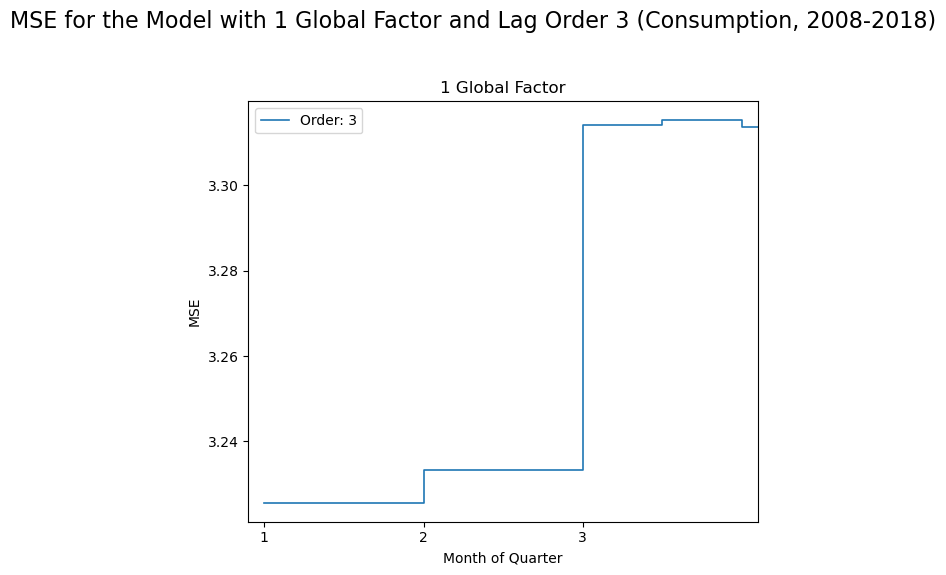

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"

# Create a single‐plot figure for 1 global factor, order 3
fig, ax = plt.subplots(figsize=(6, 6), sharey=True)

num_factors = 1
order = 3
    
# Construct file name based on the model's parameters
factors_str = f"Global_{num_factors}_{order}"
mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
mse_file_path = os.path.join(mse_dir, mse_file_name)

# Load the MSE values from file
mse_df = pd.read_csv(mse_file_path)
# Construct y values based on the vintages
y_values = [mse_df[col].iloc[0] for col in vintage_col_names]

# Extend the y-values so the step function holds the last value
y_extended = y_values.copy()
y_extended.append(y_values[-1]) # Repeat the last value

# Plot the step function for the current model
ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
         label=f"Order: {order}")

# Customize the subplot
ax.set_xlabel("Month of Quarter")
# Set ticks only at 1, 2, and 3 to mark the beginning of each month
ax.set_xticks([1, 2, 3])
ax.set_xlim(0.9, 4.1)
ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
ax.set_ylabel("MSE")
ax.legend()

plt.suptitle(f"MSE for the Model with 1 Global Factor and Lag Order 3 ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")

plt.show()

Plot MSE values for the model with 1 Global Factor and Lag Order 3 evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


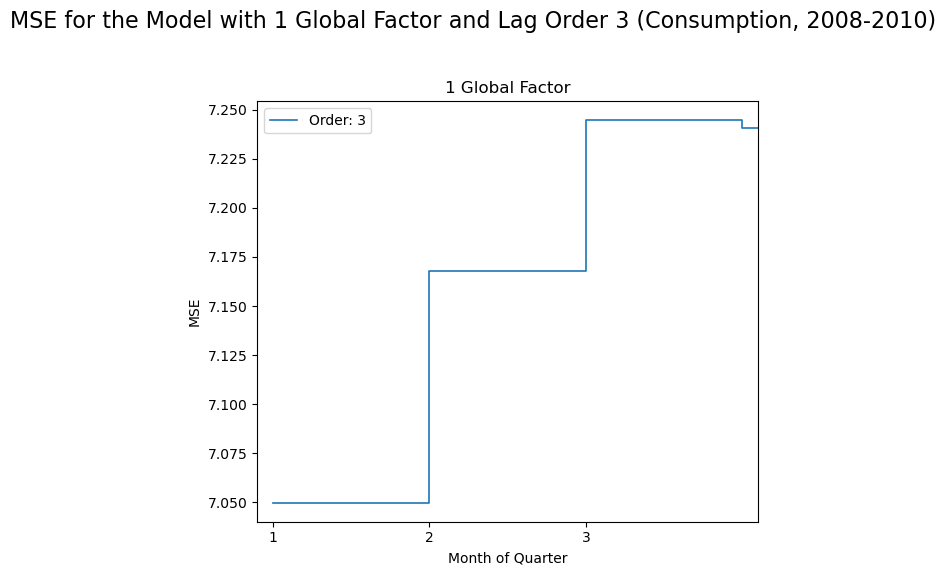

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


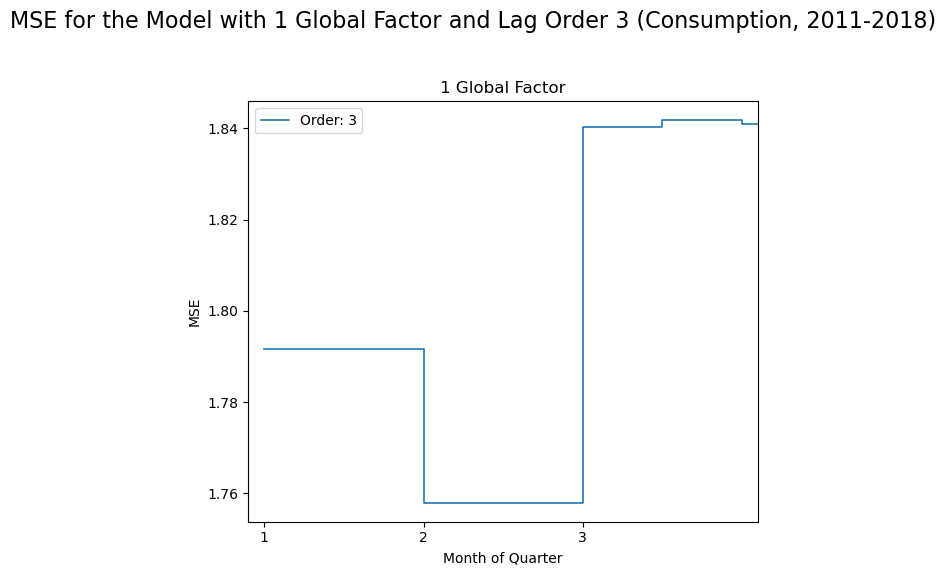

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a single‐plot figure for 1 global factor, order 3
    fig, ax = plt.subplots(figsize=(6, 6), sharey=True)
    
    num_factors = 1
    order = 3
    
    # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
    factors_str = f"Global_{num_factors}_{order}"
    forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
    forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

    # Load forecast data 
    forecasts = pd.read_csv(forecast_file_path, index_col=0)
    forecasts.index.name = "date"
    forecasts.reset_index(inplace=True)

    # Merge forecasts with actual growth 
    merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
    merged["date_float"] = merged["date"].apply(quarter_to_float)
    merged.sort_values("date_float", inplace=True)

    # Filter merged data for the current period
    merged_period = merged[ period_filter(merged) ]

    # Calculate MSE for each vintage column over the filtered period
    mse_dict = {}
    for col in vintage_col_names:
        mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
        mse_dict[col] = mse

    # Construct y values based on the vintages
    y_values = [mse_dict[col] for col in vintage_col_names]

    # Extend the y-values so the step function holds the last value
    y_extended = y_values.copy()
    y_extended.append(y_values[-1]) # Repeat the last value

    # Plot the step function for the current model (order)
    ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
            label=f"Order: {order}")
            
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    ax.set_ylabel("MSE")
    ax.legend()
   
    plt.suptitle(f"MSE for the Model with 1 Global Factor and Lag Order 3 ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")

    plt.show()

Plot forecasts vs actual growth values for the model with 1 Global Factor, Lag Order 3 and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


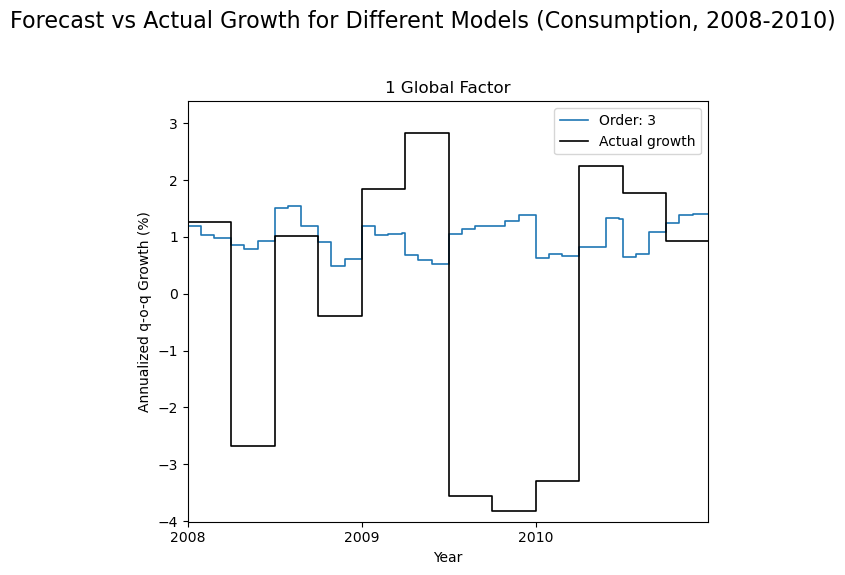

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


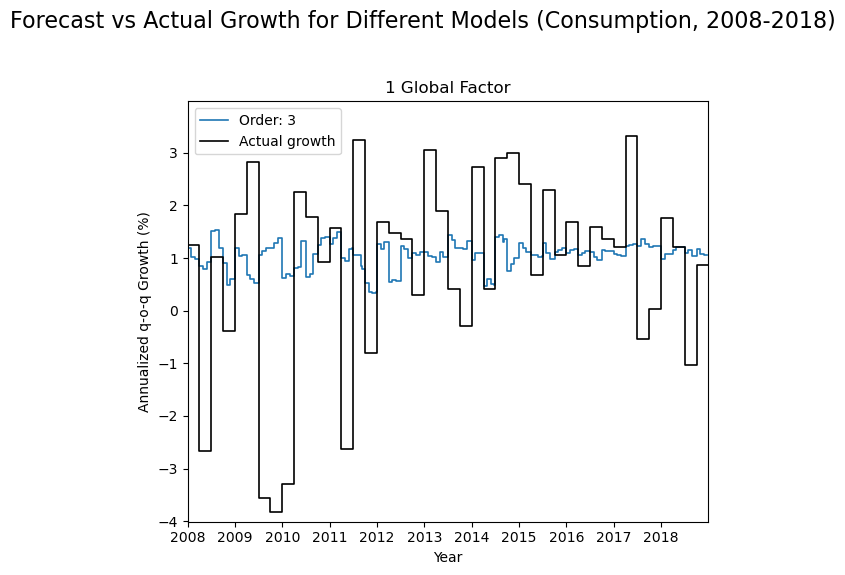

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


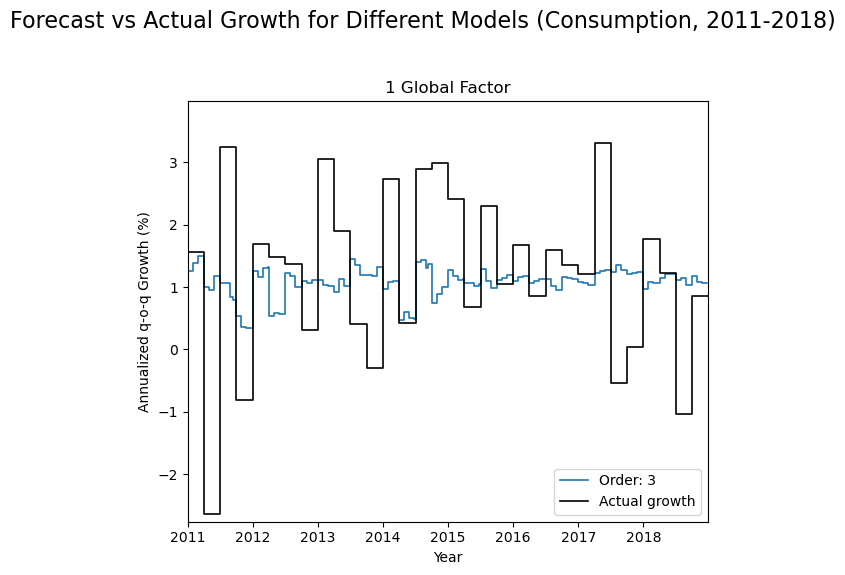

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a single‐plot figure for 1 global factor, order 3
    fig, ax = plt.subplots(figsize=(6, 6), sharey=True)

    num_factors = 1
    order = 3

    # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
    factors_str = f"Global_{num_factors}_{order}"
    forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
    forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

    # Load forecast data 
    forecasts = pd.read_csv(forecast_file_path, index_col=0)
    forecasts.index.name = "date"
    forecasts.reset_index(inplace=True)

    # Merge forecasts with actual growth dates
    merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
    merged["date_float"] = merged["date"].apply(quarter_to_float)
    merged.sort_values("date_float", inplace=True)

    # Build forecast x and y arrays 
    x_fore = []
    y_fore = []
    for idx, row in merged.iterrows():
        base_x = row["date_float"]
        # For each of the 7 vintage columns, define an x-position and take that forecast value
        for j, col in enumerate(vintage_col_names):
            x_fore.append(base_x + offsets[j])
            y_fore.append(row[col])

    # Plot the forecast step curve for the current order
    ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

    # Plot actual growth as a step plot in each subplot
    ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

    # Customize the subplot
    ax.set_xlabel("Year")
    ax.set_xlim(config["xlim"][0], config["xlim"][1])
    ax.set_xticks(config["xticks"])

    # Set y-axis limits based on the data within the period range
    x_min, x_max = config["xlim"]
    def filter_points(x_arr, y_arr, x_min, x_max):
        return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

    # Filter y-values
    y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
    y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)

    # Combine all filtered y-values
    combined_y = y_filtered + y_act_filtered
    ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))

    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    ax.set_ylabel("Annualized q-o-q Growth (%)")
    ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")

    plt.show()